In [1]:
import numpy as np
import torch
import pyepo

# set random seed
np.random.seed(42)
torch.manual_seed(42)

Auto-Sklearn cannot be imported.


## Data Set and Optimization Solver

In [2]:
# generate data
num_node = 20 # node size
num_data = 1000 # number of training data
num_feat = 10 # size of feature
deg = 4 # polynomial degree
e = 0.5 # noise width
feats, costs = pyepo.data.tsp.genData(num_data+100+1000, num_feat, num_node+1, deg, e, seed=42)

In [3]:
from model import vrpModel
# demands
demands = np.random.rand(num_node) * 10
# set solver
optmodel = vrpModel(num_node+1, demands=demands, capacity=30, num_vehicle=5)
# set time limit
optmodel._model.Params.timelimit = 30
# solve
optmodel.setObj(costs[0])
sol, obj = optmodel.solve()
print("Obj: {:.4f}".format(obj))
route = optmodel.getTour(sol)
for tour in route:
    print(" -> ".join(map(str, tour)))

Set parameter Username
Academic license - for non-commercial use only - expires 2024-10-22
Obj: 62.8136
0 -> 1 -> 17 -> 9 -> 19 -> 6 -> 14 -> 16 -> 4 -> 0
0 -> 3 -> 5 -> 0
0 -> 7 -> 15 -> 18 -> 13 -> 20 -> 12 -> 0
0 -> 8 -> 11 -> 2 -> 10 -> 0


In [4]:
# split data
from sklearn.model_selection import train_test_split
feats, x_test, costs, c_test = train_test_split(feats, costs, test_size=1000, random_state=42)
x_train, x_val, c_train, c_val = train_test_split(feats, costs, test_size=100, random_state=42)

In [5]:
# get training, validation and test dataset
dataset_train_cost = pyepo.data.dataset.optDataset(optmodel, x_train, costs=c_train)
dataset_val = pyepo.data.dataset.optDataset(optmodel, x_val, costs=c_val)
dataset_test = pyepo.data.dataset.optDataset(optmodel, x_test, costs=c_test)

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:50<00:00,  3.44it/s]


Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.26it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:34<00:00,  6.46it/s]


In [6]:
from dataset import optDatasetConstrs
dataset_train = optDatasetConstrs(optmodel, x_train, costs=c_train)

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [10:29<00:00,  1.59it/s]


In [7]:
# get data loader
from torch.utils.data import DataLoader
from dataset import collate_fn
batch_size = 32
loader_train_cost = DataLoader(dataset_train_cost, batch_size=batch_size, shuffle=True)
loader_train = DataLoader(dataset_train, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
loader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

## Prediction Model

In [8]:
import torch
from torch import nn

# build linear model
class LinearRegression(nn.Module):

    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(num_feat, num_node*(num_node+1)//2)

    def forward(self, x):
        out = self.linear(x)
        return out

## Plot 

In [9]:
from matplotlib import pyplot as plt

def plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step):
    # draw loss plot for training
    plt.figure(figsize=(16, 8))
    plt.plot(loss_log, color="c", lw=2)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Iters", fontsize=36)
    plt.ylabel("Loss", fontsize=36)
    plt.title("Loss Curve on Training Set", fontsize=36)
    plt.show()
    # draw grad plot for training
    plt.figure(figsize=(16, 8))
    plt.plot(grad_log, color="g", alpha=0.5, lw=2)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.gca().yaxis.get_offset_text().set_size(24)
    plt.xlabel("Iters", fontsize=36)
    plt.ylabel("Abs Grad", fontsize=36)
    plt.title("Absolute Gradient Curve on Training Set", fontsize=36)
    plt.show()
    # draw regret plot for test
    fig = plt.figure(figsize=(16, 8))
    plt.plot([i * log_step for i in range(len(regret_log_trn))], regret_log_trn,
             color="royalblue", ls="--", alpha=0.7, lw=5, label="Train")
    plt.plot([i * log_step for i in range(len(regret_log_val))], regret_log_val,
             color="lightcoral", ls=":", alpha=0.7, lw=5, label="Val")
    plt.xlim(-0.5, num_epochs+0.5)
    plt.ylim(0, 0.5)
    plt.xticks(range(0, num_epochs+1, 5), fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Epoch", fontsize=36)
    plt.ylabel("Regret", fontsize=36)
    plt.legend(fontsize=32)
    plt.title("Regret Curve on Training and Validation Set", fontsize=36)
    plt.show()

## Train

In [10]:
num_epochs = 20
log_step = 1

In [11]:
import copy
import time
from tqdm import tqdm
from earlystop import earlyStopper
from clipgrad import clipGrad

def pipeline(reg, forward_func, loss_func, lr, num_epochs, 
             log_step, loader_train, loader_val, loader_test, grad_clip=False, seed=42):
    # set random seed
    np.random.seed(seed)
    torch.manual_seed(seed)
    # set optimizer
    optimizer = torch.optim.Adam(reg.parameters(), lr=lr)
    # set stopper
    stopper = earlyStopper(patience=3)
    stop = False
    # init best model
    best_model_state = copy.deepcopy(reg.state_dict())
    best_val_regret = float("inf")
    # init log
    loss_log = []
    grad_log = []
    regret_log_trn = []
    regret_log_val = []
    # running time
    elapsed = 0
    tbar = tqdm(range(num_epochs))
    for epoch in tbar:
        # eval & log
        if epoch % log_step == 0:
            # regret
            regret_trn = pyepo.metric.regret(reg, optmodel, loader_train_cost)
            regret_log_trn.append(regret_trn)
            regret_val = pyepo.metric.regret(reg, optmodel, loader_val)
            regret_log_val.append(regret_val)
            tbar.write("Epoch {:3}, Train Regret: {:8.4f}%, Val Regret: {:8.4f}%".format(epoch, regret_trn*100, regret_val*100))
            # update best model
            if regret_val < best_val_regret:
                best_val_regret = regret_val
                best_model_state = copy.deepcopy(reg.state_dict())
            # early stop
            if stopper.stop(regret_val):
                print()
                stop = True
                print("Early Stop!")
                break
        # training
        time.sleep(1)
        tick = time.time()
        for data in loader_train:
            # forward pass
            loss = forward_func(data, reg, loss_func, grad_log)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # clip
            if grad_clip:
                clipGrad(reg, threshold=1e-6)
            optimizer.step()
            loss_log.append(loss.item())
            tbar.set_description("Epoch {:4.0f}, Loss: {:8.4f}".format(epoch, loss.item()))
        # record time
        tock = time.time()
        elapsed += tock - tick
    # no early stop
    if not stop:
        regret_trn = pyepo.metric.regret(reg, optmodel, loader_train_cost)
        regret_log_trn.append(regret_trn)
        regret_val = pyepo.metric.regret(reg, optmodel, loader_val)
        regret_log_val.append(regret_val)
        tbar.write("Epoch {:3}, Train Regret: {:8.4f}%, Val Regret: {:8.4f}%".format(epoch, regret_trn*100, regret_val*100))
        # update best model
        if regret_val < best_val_regret:
            best_val_regret = regret_val
            best_model_state = copy.deepcopy(reg.state_dict())
    print("Training Elapsed Time: {:.2f} Sec".format(elapsed))
    # restore best model
    reg.load_state_dict(best_model_state)
    print()
    print("Evaluation:")
    tick = time.time()
    test_regret = pyepo.metric.regret(reg, optmodel, loader_test)
    tock = time.time()
    elapsed = tock - tick
    print("Test Regret: {:.4f}%".format(test_regret*100))
    print("Test Elapsed Time: {:.2f} Sec".format(elapsed))
    return loss_log, grad_log, regret_log_trn, regret_log_val


def forwardCAVE(data, reg, loss_func, grad_log):
    # unzip data
    x, _, _, t_ctr = data
    # predict
    cp = reg(x)
    # get gradient
    cp.register_hook(lambda grad: grad_log.append(abs(grad.cpu().detach().numpy()).sum()))
    # loss
    loss = loss_func(cp, t_ctr)
    return loss

### 2-Stage 

In [12]:
# init model
reg = LinearRegression()

In [13]:
from torch import nn
# init loss
mse = nn.MSELoss()

def forward2S(data, reg, loss_func, grad_log):
    # unzip data
    x, c, w, z = data
    # predict
    cp = reg(x)
    # get gradient
    cp.register_hook(lambda grad: grad_log.append(abs(grad.cpu().detach().numpy()).sum()))
    # loss
    loss = loss_func(cp, c)
    return loss

In [14]:
lr = 5e-2
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forward2S, mse, lr, num_epochs, log_step,
                                                              loader_train_cost, loader_val, loader_test)

  0%|                                                                                          | 0/20 [02:35<?, ?it/s]

Epoch   0, Train Regret: 161.4252%, Val Regret: 167.6228%


Epoch    0, Loss:  34.3776:   5%|██▋                                                  | 1/20 [07:19<49:57, 157.75s/it]

Epoch   1, Train Regret:  18.2238%, Val Regret:  18.5719%


Epoch    1, Loss:  16.6345:  10%|█████                                              | 2/20 [13:13<1:09:24, 231.39s/it]

Epoch   2, Train Regret:  16.0675%, Val Regret:  16.6149%


Epoch    2, Loss:  17.3462:  15%|███████▋                                           | 3/20 [19:03<1:21:22, 287.23s/it]

Epoch   3, Train Regret:  15.2584%, Val Regret:  16.2108%


Epoch    3, Loss:  14.7752:  20%|██████████▏                                        | 4/20 [26:04<1:23:10, 311.93s/it]

Epoch   4, Train Regret:  14.3627%, Val Regret:  14.6587%


Epoch    4, Loss:  17.4309:  25%|████████████▊                                      | 5/20 [31:51<1:27:53, 351.58s/it]

Epoch   5, Train Regret:  13.4866%, Val Regret:  13.4888%


Epoch    5, Loss:  11.6864:  30%|███████████████▎                                   | 6/20 [39:27<1:21:39, 349.96s/it]

Epoch   6, Train Regret:  12.4005%, Val Regret:  12.5449%


Epoch    6, Loss:   8.2875:  35%|█████████████████▊                                 | 7/20 [46:31<1:23:20, 384.64s/it]

Epoch   7, Train Regret:  11.6580%, Val Regret:  11.7315%


Epoch    7, Loss:  13.1146:  40%|████████████████████▍                              | 8/20 [55:56<1:19:23, 396.96s/it]

Epoch   8, Train Regret:  11.1528%, Val Regret:  11.1827%


Epoch    8, Loss:   6.7146:  45%|██████████████████████                           | 9/20 [1:02:13<1:22:24, 449.50s/it]

Epoch   9, Train Regret:  10.7524%, Val Regret:  11.0440%


Epoch    9, Loss:  10.0623:  50%|████████████████████████                        | 10/20 [1:10:15<1:11:12, 427.29s/it]

Epoch  10, Train Regret:  10.6427%, Val Regret:  10.6869%


Epoch   10, Loss:   6.3220:  55%|██████████████████████████▍                     | 11/20 [1:19:52<1:06:36, 444.08s/it]

Epoch  11, Train Regret:  10.4659%, Val Regret:  10.7719%


Epoch   11, Loss:   9.7752:  60%|████████████████████████████▊                   | 12/20 [1:24:47<1:04:34, 484.33s/it]

Epoch  12, Train Regret:  10.5188%, Val Regret:  10.4103%


Epoch   12, Loss:  16.0403:  65%|████████████████████████████████▌                 | 13/20 [1:33:28<49:49, 427.12s/it]

Epoch  13, Train Regret:  10.4327%, Val Regret:  10.4853%


Epoch   13, Loss:   5.8978:  70%|███████████████████████████████████               | 14/20 [1:42:54<45:31, 455.29s/it]

Epoch  14, Train Regret:  10.4862%, Val Regret:  10.6587%


Epoch   14, Loss:  14.7167:  75%|█████████████████████████████████████▌            | 15/20 [1:51:29<37:09, 445.94s/it]


Epoch  15, Train Regret:  10.3836%, Val Regret:  11.1399%

Early Stop!
Training Elapsed Time: 2.94 Sec

Evaluation:
Test Regret: 10.6677%
Test Elapsed Time: 371.56 Sec


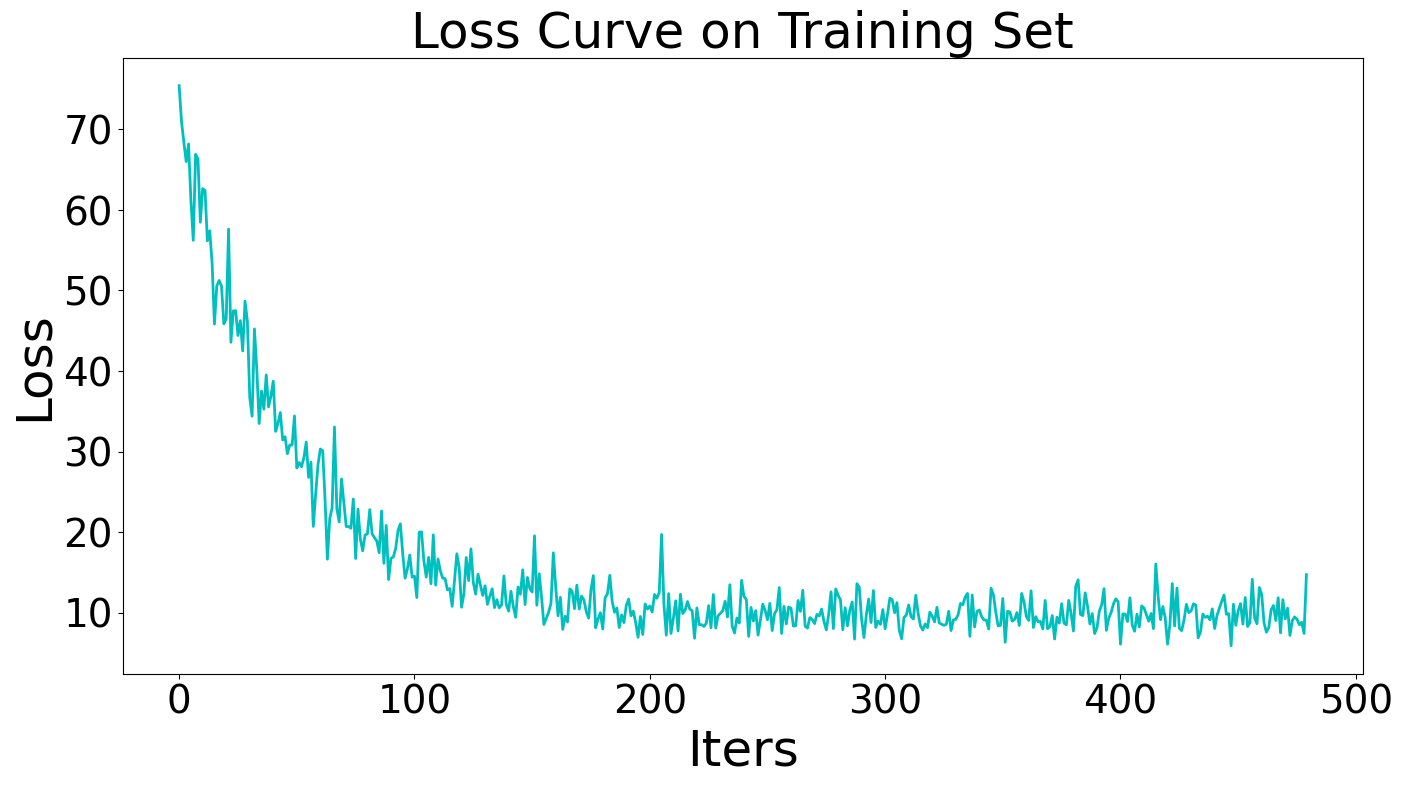

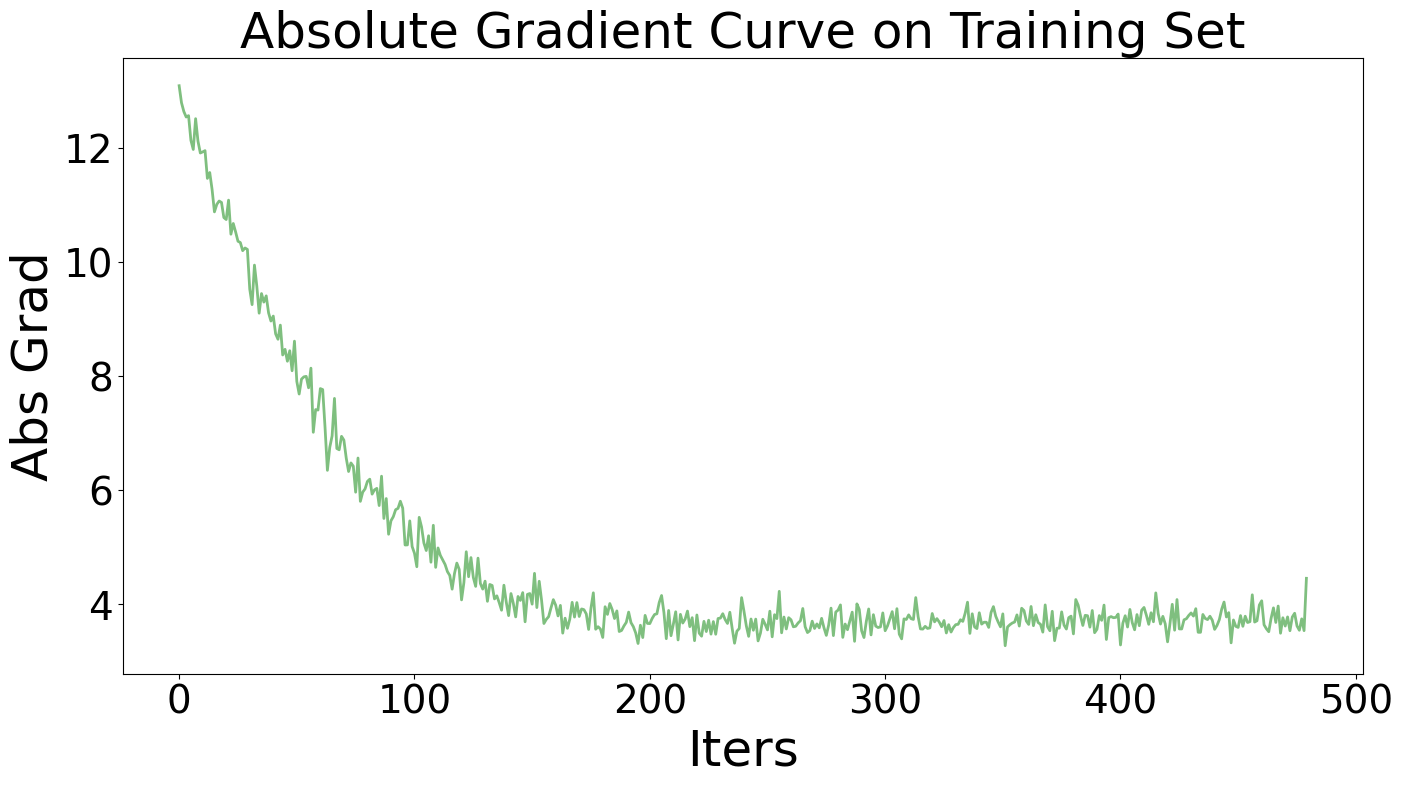

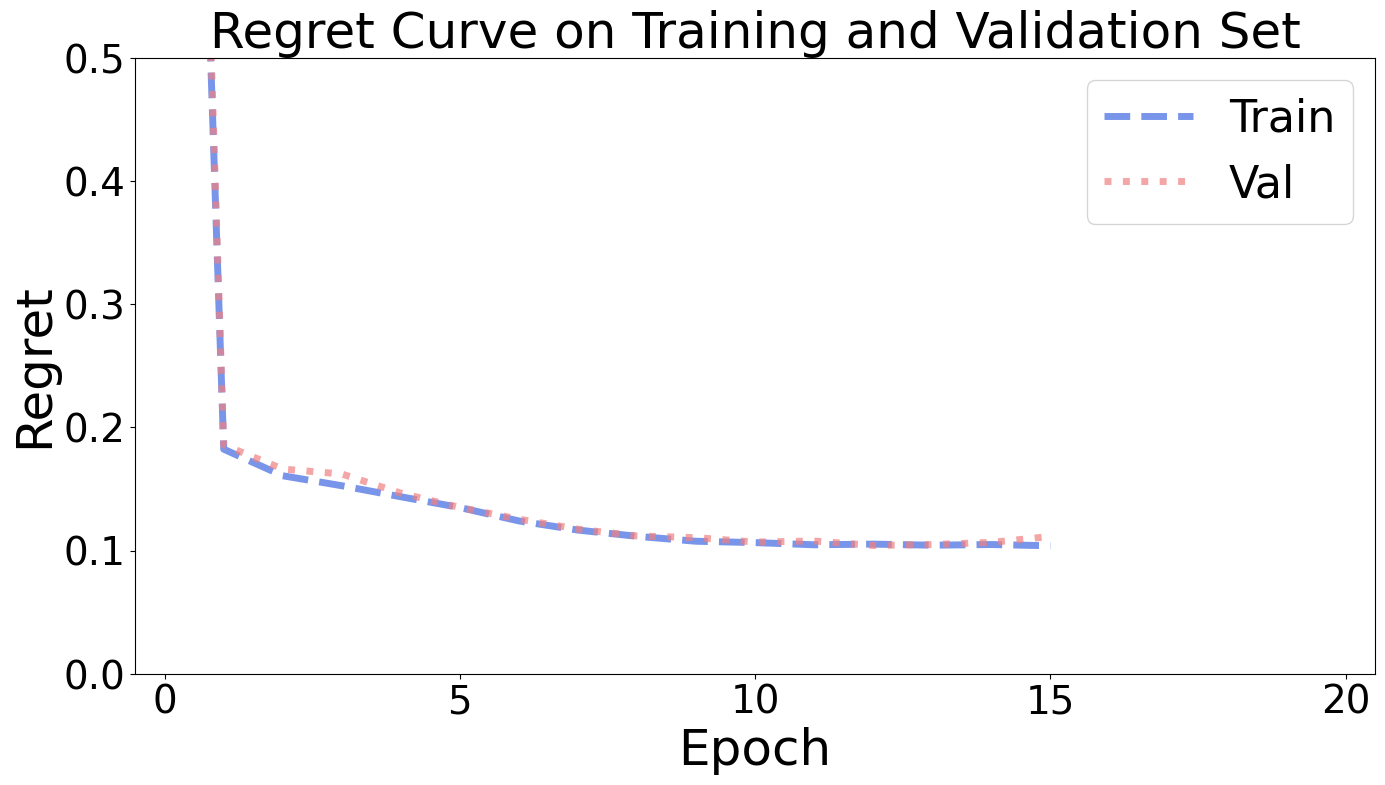

In [15]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Exact Method with Clarabel

In [16]:
# init model
reg = LinearRegression()

In [17]:
from func import exactConeAlignedCosine
# init loss
ca_cos = exactConeAlignedCosine(optmodel, solver="clarabel", processes=8)

Num of cores: 8


In [18]:
lr = 1e-1
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                          | 0/20 [01:58<?, ?it/s]

Epoch   0, Train Regret: 165.4472%, Val Regret: 166.9605%


Epoch    0, Loss:  -0.9973:   5%|██▋                                                  | 1/20 [04:47<50:42, 160.13s/it]

Epoch   1, Train Regret:  11.1351%, Val Regret:  12.3175%


Epoch    1, Loss:  -0.9990:  10%|█████▎                                               | 2/20 [07:21<42:54, 143.03s/it]

Epoch   2, Train Regret:   8.4032%, Val Regret:  10.3120%


Epoch    2, Loss:  -0.9987:  15%|███████▉                                             | 3/20 [10:03<41:54, 147.89s/it]

Epoch   3, Train Regret:   7.6335%, Val Regret:   8.7266%


Epoch    3, Loss:  -0.9991:  20%|██████████▌                                          | 4/20 [13:13<40:55, 153.45s/it]

Epoch   4, Train Regret:   7.4166%, Val Regret:   8.9430%


Epoch    4, Loss:  -0.9993:  25%|█████████████▎                                       | 5/20 [16:06<41:39, 166.60s/it]

Epoch   5, Train Regret:   7.2547%, Val Regret:   8.0109%


Epoch    5, Loss:  -0.9989:  30%|███████████████▉                                     | 6/20 [19:36<39:23, 168.79s/it]

Epoch   6, Train Regret:   7.0307%, Val Regret:   7.8664%


Epoch    6, Loss:  -0.9994:  35%|██████████████████▌                                  | 7/20 [23:48<39:29, 182.24s/it]

Epoch   7, Train Regret:   6.9649%, Val Regret:   8.0065%


Epoch    7, Loss:  -0.9996:  40%|█████████████████████▏                               | 8/20 [27:24<40:55, 204.63s/it]

Epoch   8, Train Regret:   7.0587%, Val Regret:   6.9095%


Epoch    8, Loss:  -0.9992:  45%|███████████████████████▊                             | 9/20 [30:58<38:11, 208.29s/it]

Epoch   9, Train Regret:   6.9278%, Val Regret:   7.4522%


Epoch    9, Loss:  -0.9996:  50%|██████████████████████████                          | 10/20 [34:42<34:59, 209.99s/it]

Epoch  10, Train Regret:   7.0044%, Val Regret:   7.6528%


Epoch   10, Loss:  -0.9995:  55%|████████████████████████████▌                       | 11/20 [39:19<32:10, 214.51s/it]


Epoch  11, Train Regret:   7.0298%, Val Regret:   7.9497%

Early Stop!
Training Elapsed Time: 67.44 Sec

Evaluation:
Test Regret: 8.0428%
Test Elapsed Time: 186.36 Sec


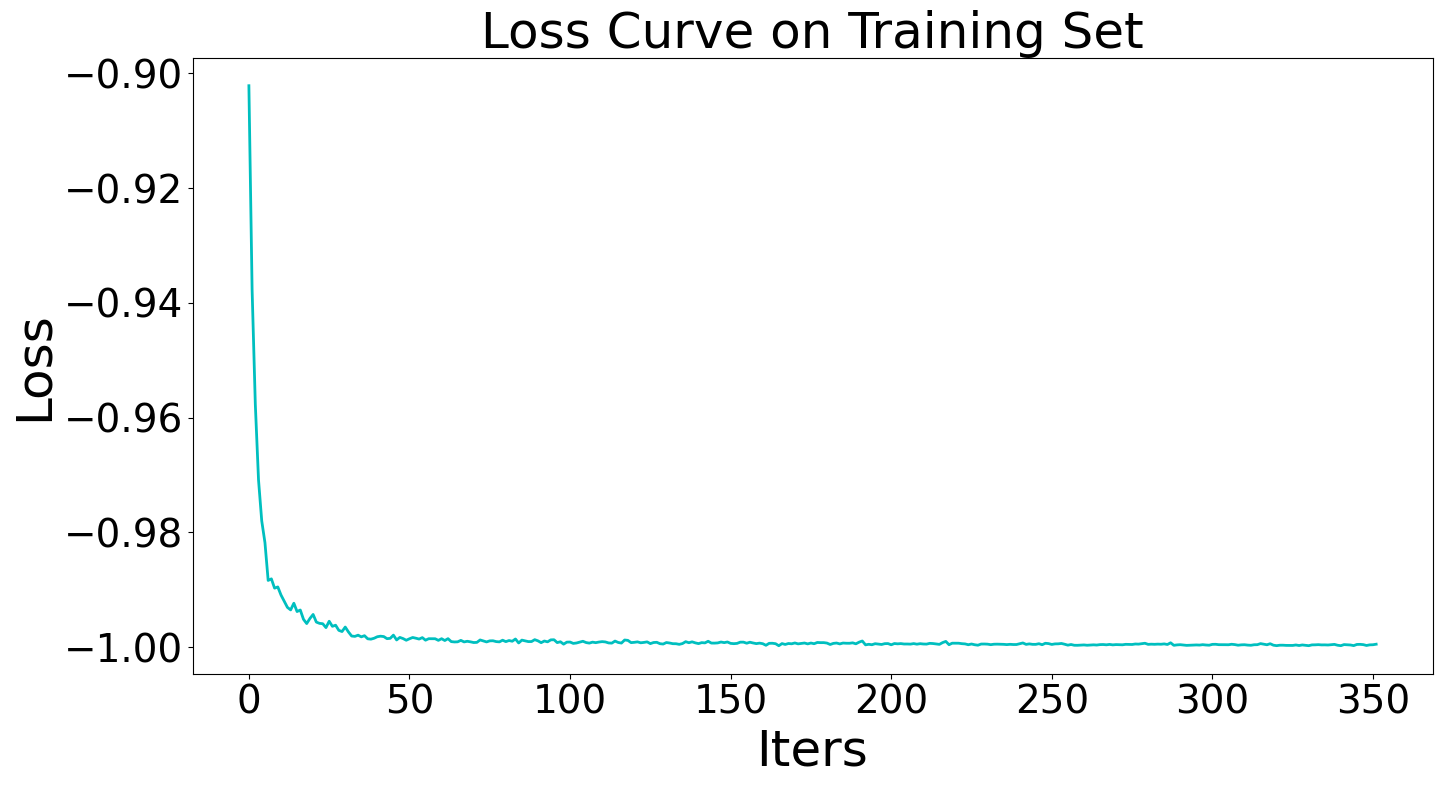

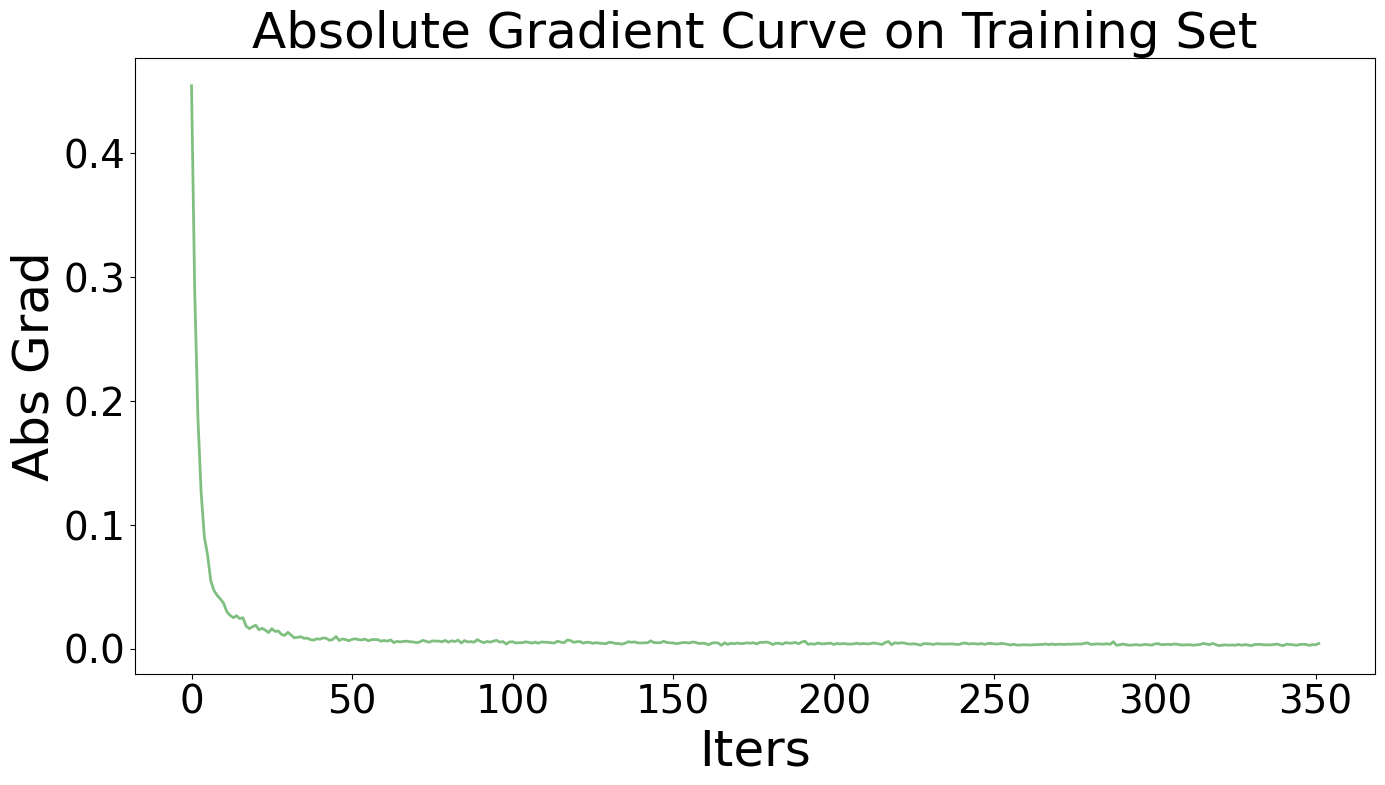

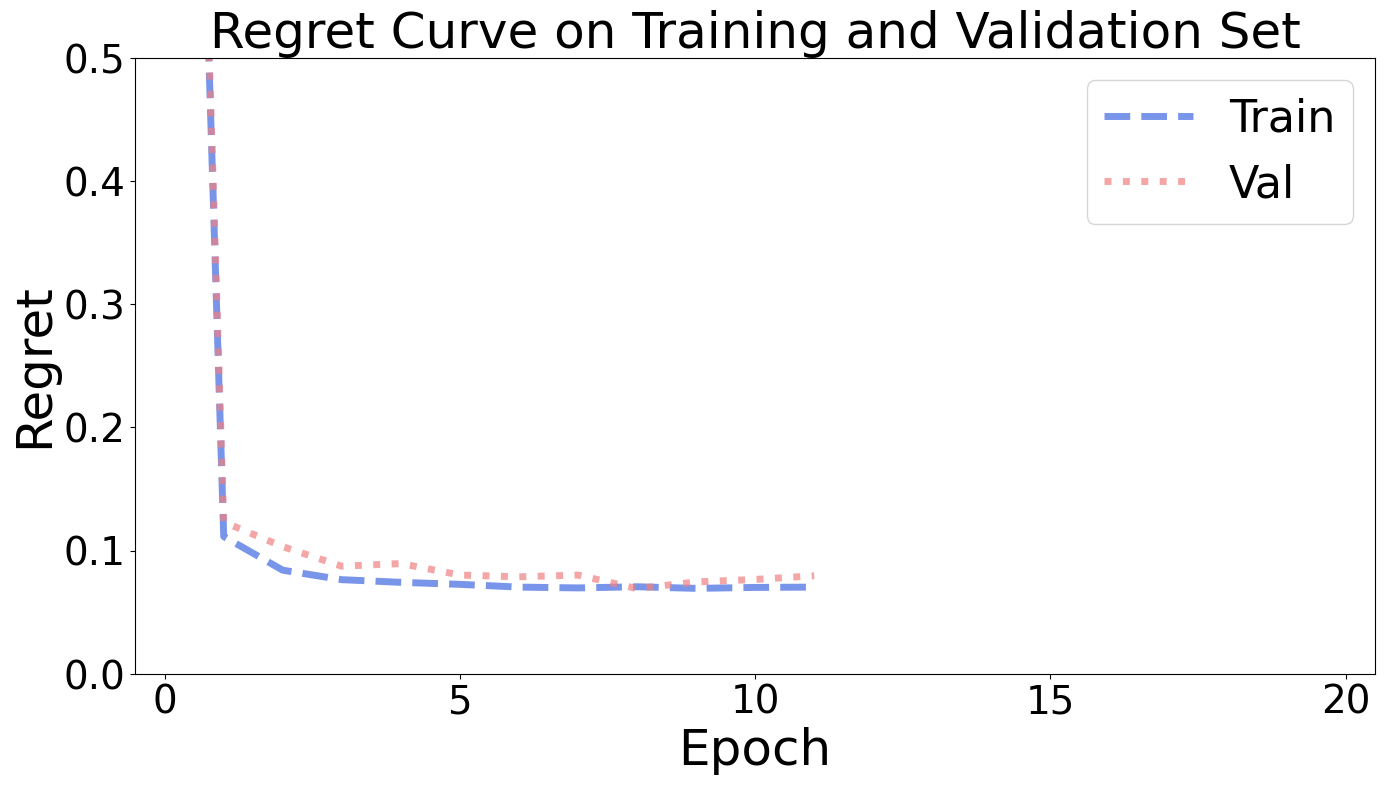

In [19]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Inner Method with Clarabel

In [20]:
# init model
reg = LinearRegression()

In [21]:
from func import innerConeAlignedCosine
# init loss
ca_cos = innerConeAlignedCosine(optmodel, solver="clarabel", processes=8)

Num of cores: 8


In [22]:
lr = 5e-2
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                          | 0/20 [02:26<?, ?it/s]

Epoch   0, Train Regret: 154.5396%, Val Regret: 163.5118%


Epoch    0, Loss:  -0.9948:   5%|██▋                                                  | 1/20 [04:45<47:25, 149.77s/it]

Epoch   1, Train Regret:   8.3005%, Val Regret:   9.7125%


Epoch    1, Loss:  -0.9967:  10%|█████▎                                               | 2/20 [07:24<43:01, 143.40s/it]

Epoch   2, Train Regret:   5.8561%, Val Regret:   6.5561%


Epoch    2, Loss:  -0.9958:  15%|███████▉                                             | 3/20 [09:58<42:43, 150.77s/it]

Epoch   3, Train Regret:   5.4619%, Val Regret:   6.2699%


Epoch    3, Loss:  -0.9963:  20%|██████████▌                                          | 4/20 [13:23<40:33, 152.10s/it]

Epoch   4, Train Regret:   5.3449%, Val Regret:   6.2921%


Epoch    4, Loss:  -0.9972:  25%|█████████████▎                                       | 5/20 [16:15<42:43, 170.90s/it]

Epoch   5, Train Regret:   5.3798%, Val Regret:   6.0799%


Epoch    5, Loss:  -0.9949:  30%|███████████████▉                                     | 6/20 [18:49<39:59, 171.41s/it]

Epoch   6, Train Regret:   5.5984%, Val Regret:   6.3233%


Epoch    6, Loss:  -0.9961:  35%|██████████████████▌                                  | 7/20 [21:36<35:52, 165.60s/it]

Epoch   7, Train Regret:   5.4501%, Val Regret:   6.8278%


Epoch    7, Loss:  -0.9963:  40%|█████████████████████▏                               | 8/20 [24:19<33:14, 166.24s/it]

Epoch   8, Train Regret:   5.3151%, Val Regret:   5.9714%


Epoch    8, Loss:  -0.9952:  45%|███████████████████████▊                             | 9/20 [26:39<30:15, 165.06s/it]

Epoch   9, Train Regret:   5.2064%, Val Regret:   6.0215%


Epoch    9, Loss:  -0.9961:  50%|██████████████████████████                          | 10/20 [29:10<26:12, 157.26s/it]

Epoch  10, Train Regret:   5.3661%, Val Regret:   6.3306%


Epoch   10, Loss:  -0.9954:  55%|████████████████████████████▌                       | 11/20 [31:46<26:00, 173.36s/it]


Epoch  11, Train Regret:   5.4075%, Val Regret:   6.9776%

Early Stop!
Training Elapsed Time: 27.67 Sec

Evaluation:
Test Regret: 6.5289%
Test Elapsed Time: 139.53 Sec


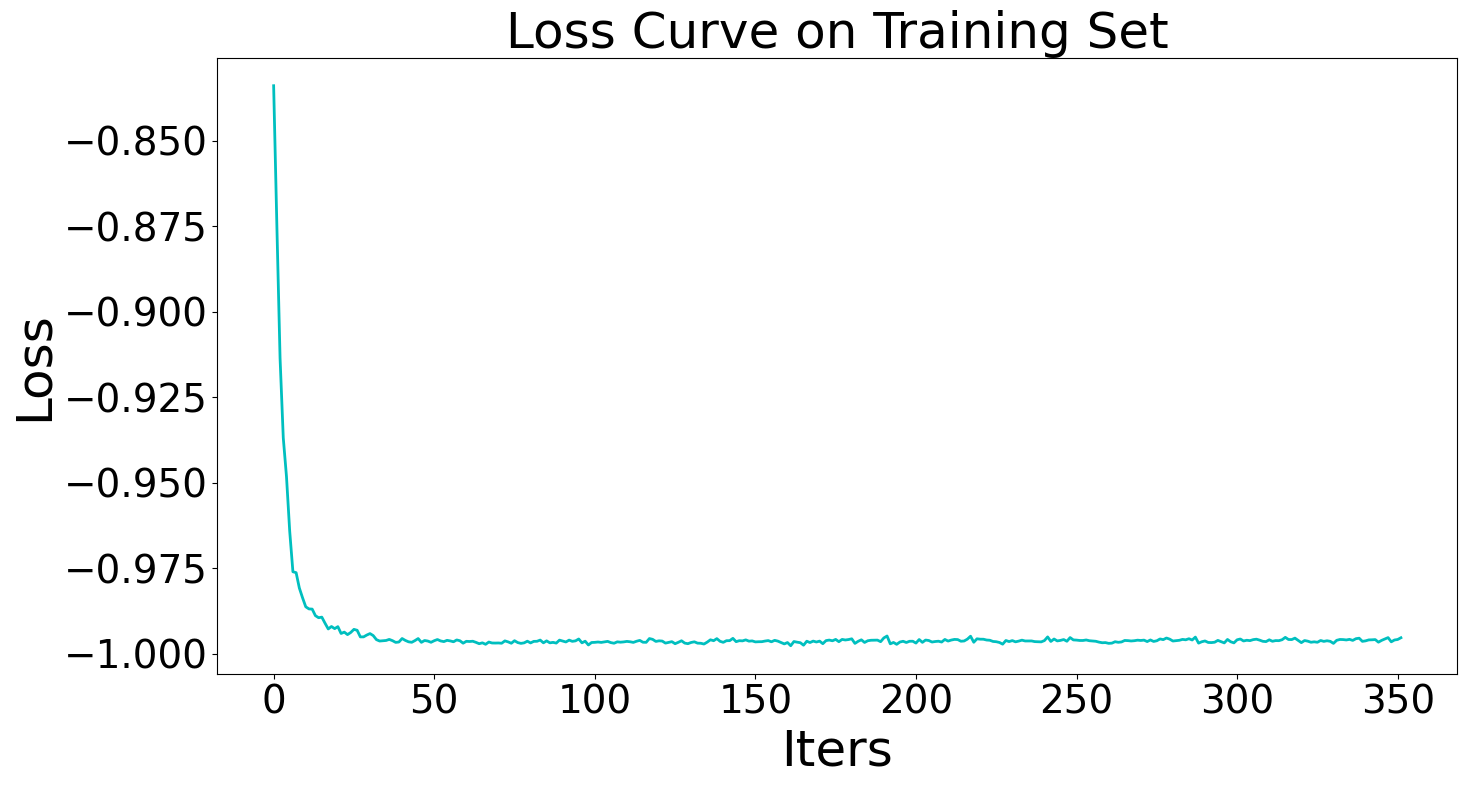

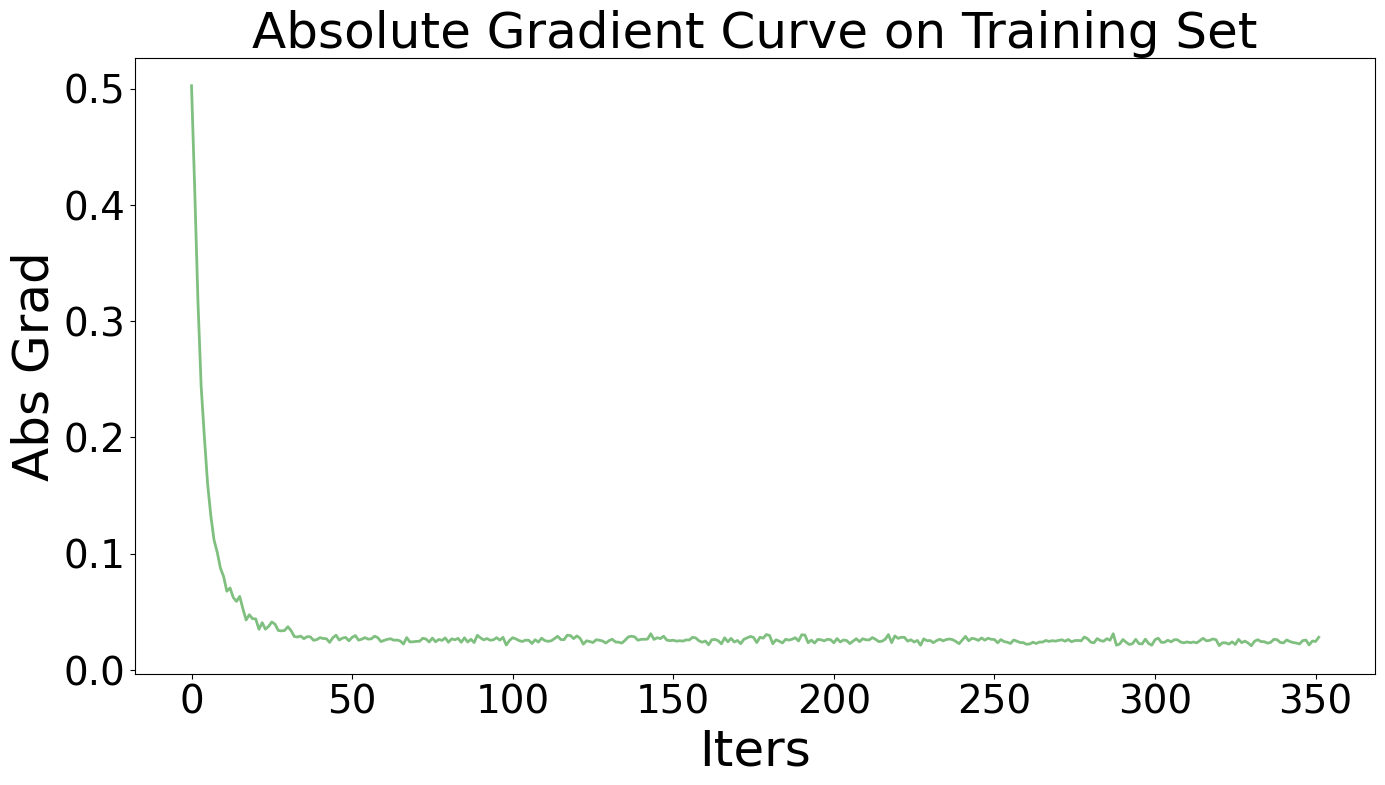

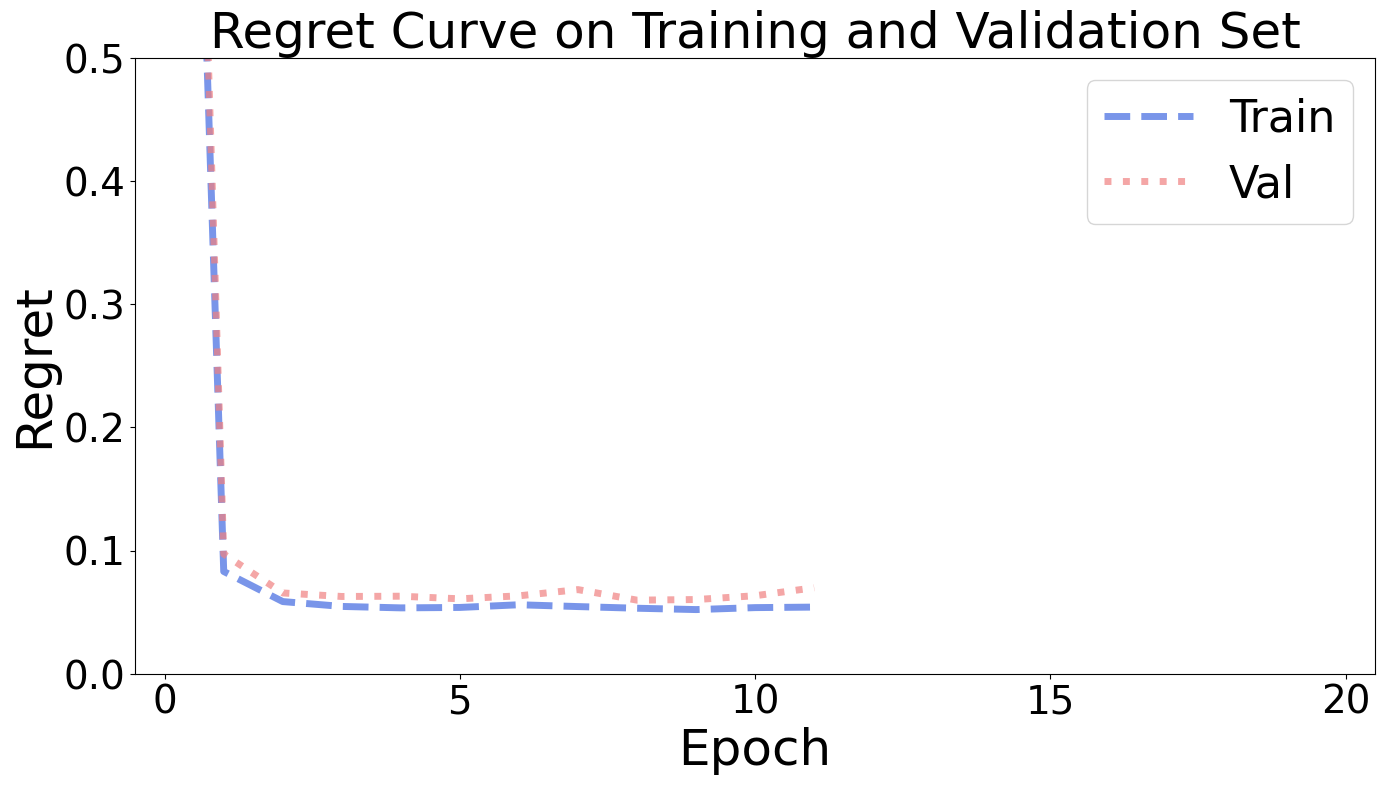

In [23]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Inner & Average Method

In [24]:
# init model
reg = LinearRegression()

In [25]:
from func import innerConeAlignedCosine
# init loss
ca_cos = innerConeAlignedCosine(optmodel, solver="clarabel", solve_ratio=0.3, processes=8)

Num of cores: 8


In [26]:
lr = 5e-2
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                          | 0/20 [02:23<?, ?it/s]

Epoch   0, Train Regret: 154.5396%, Val Regret: 163.5118%


Epoch    0, Loss:  -0.9940:   5%|██▋                                                  | 1/20 [04:35<46:00, 145.28s/it]

Epoch   1, Train Regret:   9.7197%, Val Regret:  11.0763%


Epoch    1, Loss:  -0.9999:  10%|█████▎                                               | 2/20 [06:50<41:14, 137.50s/it]

Epoch   2, Train Regret:   7.1583%, Val Regret:   7.7915%


Epoch    2, Loss:  -0.9999:  15%|███████▉                                             | 3/20 [08:58<38:36, 136.27s/it]

Epoch   3, Train Regret:   6.7282%, Val Regret:   7.4841%


Epoch    3, Loss:  -0.9999:  20%|██████████▌                                          | 4/20 [11:14<35:32, 133.28s/it]

Epoch   4, Train Regret:   6.5638%, Val Regret:   7.2861%


Epoch    4, Loss:  -0.9999:  25%|█████████████▎                                       | 5/20 [13:21<33:31, 134.09s/it]

Epoch   5, Train Regret:   6.2308%, Val Regret:   6.8340%


Epoch    5, Loss:  -0.9996:  30%|███████████████▉                                     | 6/20 [15:35<30:43, 131.67s/it]

Epoch   6, Train Regret:   6.5911%, Val Regret:   7.2908%


Epoch    6, Loss:  -0.9999:  35%|██████████████████▌                                  | 7/20 [17:47<28:40, 132.33s/it]

Epoch   7, Train Regret:   6.6803%, Val Regret:   7.6903%


Epoch    7, Loss:  -0.9998:  40%|█████████████████████▏                               | 8/20 [19:51<29:47, 148.98s/it]


Epoch   8, Train Regret:   6.5711%, Val Regret:   7.1164%

Early Stop!
Training Elapsed Time: 8.98 Sec

Evaluation:
Test Regret: 7.2573%
Test Elapsed Time: 124.68 Sec


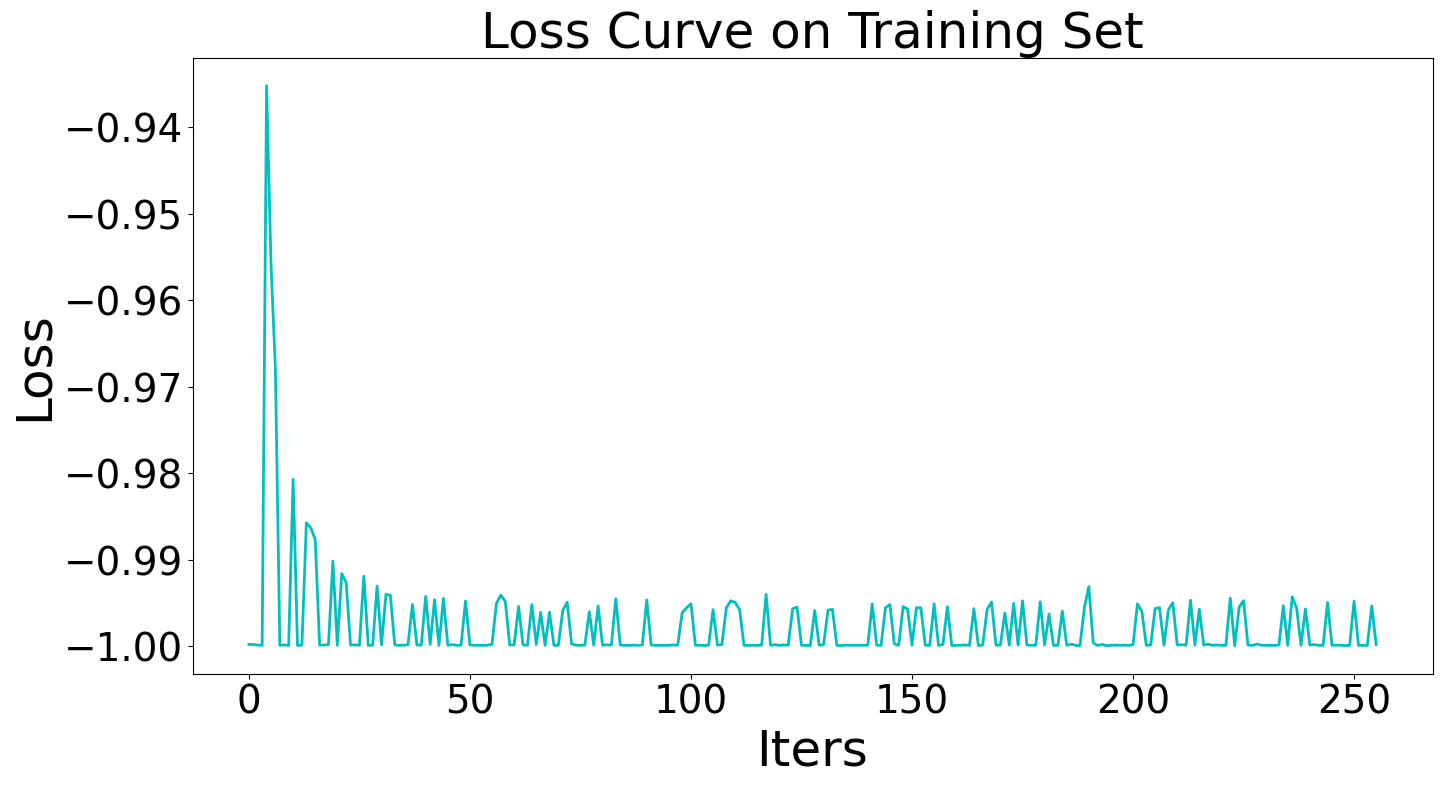

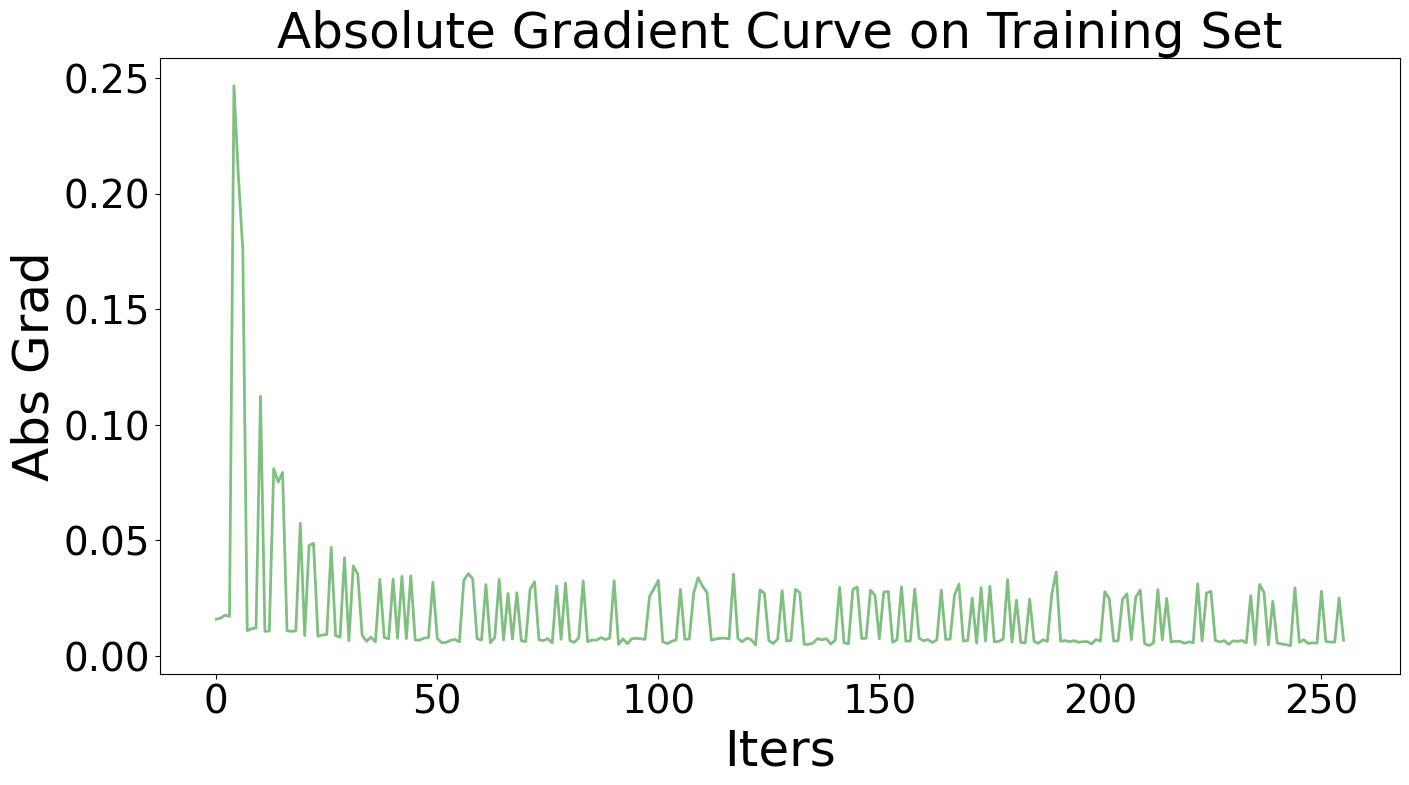

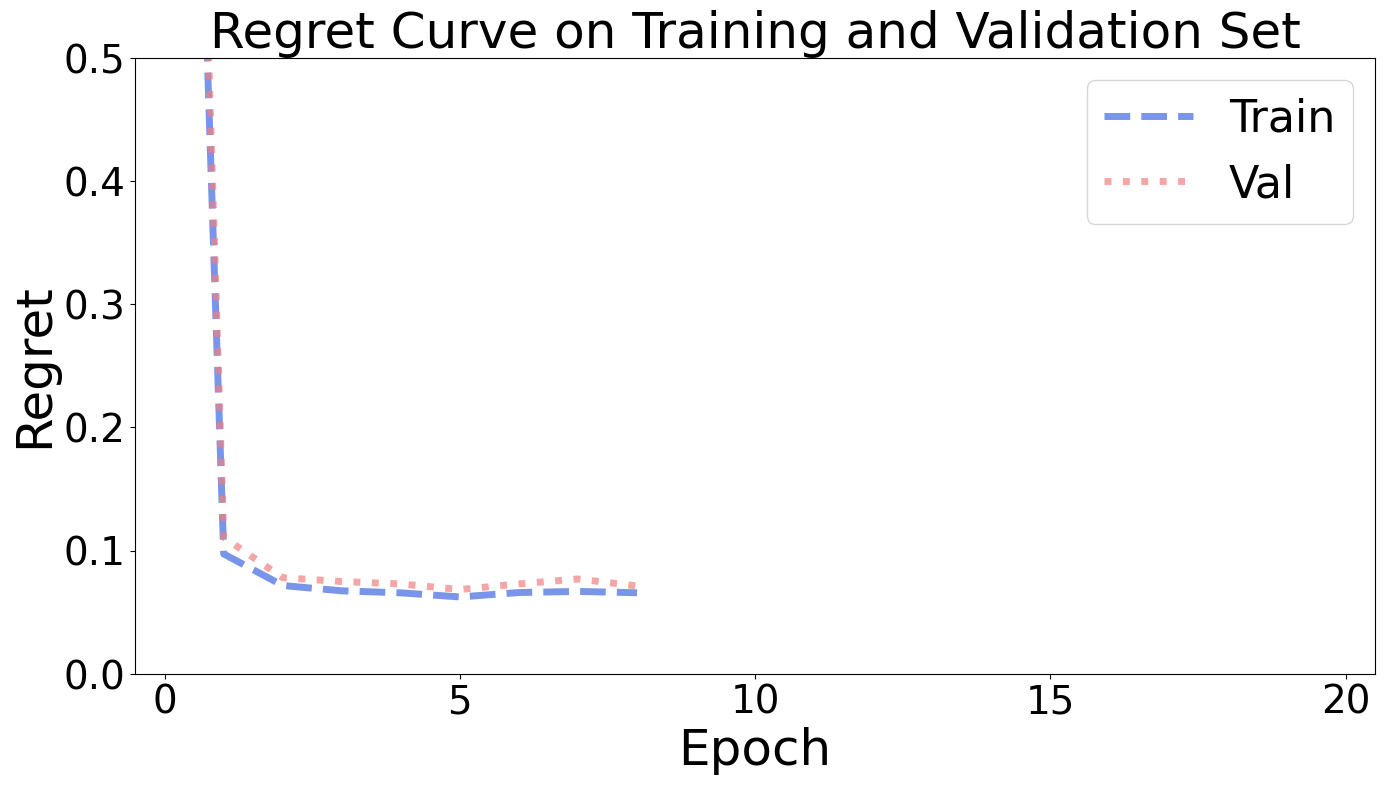

In [27]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Sampling Method

In [28]:
# init model
reg = LinearRegression()

In [29]:
from func import samplingConeAlignedCosine
# init loss
ca_cos = samplingConeAlignedCosine(optmodel, n_samples=100, inner_ratio=0.4)

Num of cores: 1


In [30]:
lr = 1e-1
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                          | 0/20 [02:29<?, ?it/s]

Epoch   0, Train Regret: 148.2452%, Val Regret: 146.1170%


Epoch    0, Loss:  -0.9994:   5%|██▋                                                  | 1/20 [04:10<48:15, 152.40s/it]

Epoch   1, Train Regret:  13.5053%, Val Regret:  14.1835%


Epoch    1, Loss:  -0.9992:  10%|█████▎                                               | 2/20 [05:41<36:31, 121.73s/it]

Epoch   2, Train Regret:  14.2135%, Val Regret:  14.9009%


Epoch    2, Loss:  -0.9993:  15%|███████▉                                             | 3/20 [07:11<30:31, 107.74s/it]

Epoch   3, Train Regret:  15.3653%, Val Regret:  16.0148%


Epoch    3, Loss:  -0.9978:  20%|██████████▌                                          | 4/20 [08:42<34:50, 130.69s/it]


Epoch   4, Train Regret:  14.6629%, Val Regret:  14.6664%

Early Stop!
Training Elapsed Time: 4.78 Sec

Evaluation:
Test Regret: 14.5955%
Test Elapsed Time: 90.58 Sec


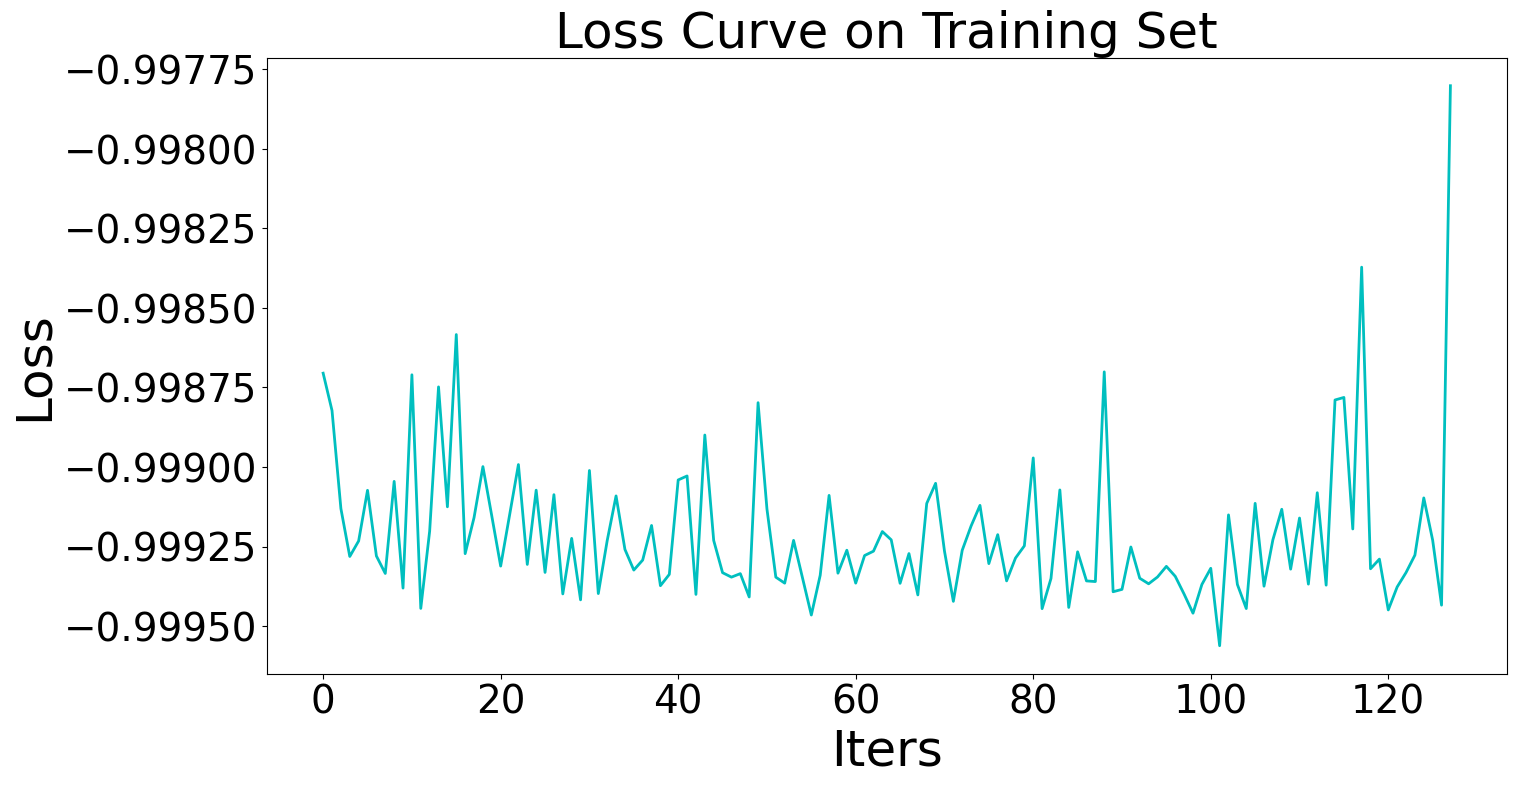

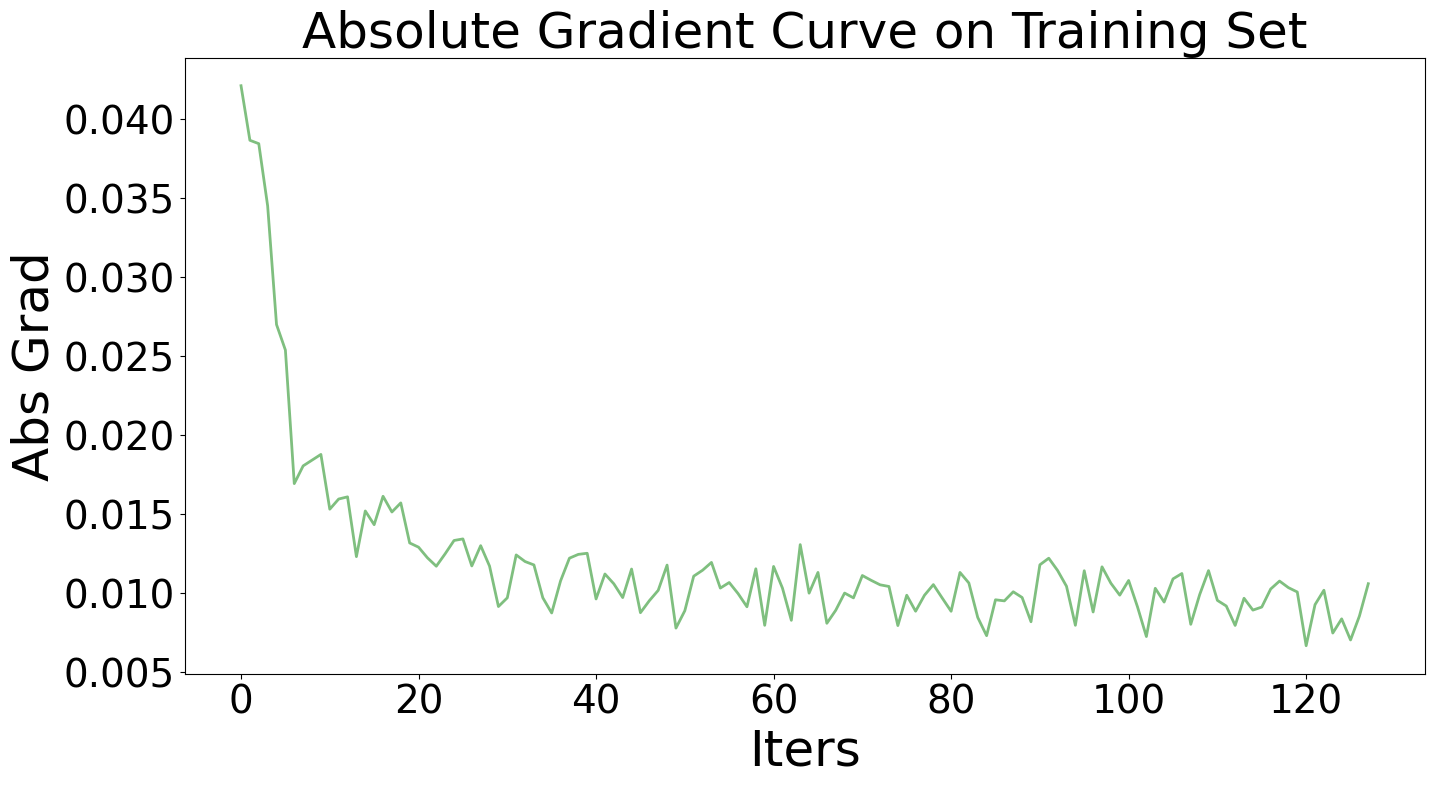

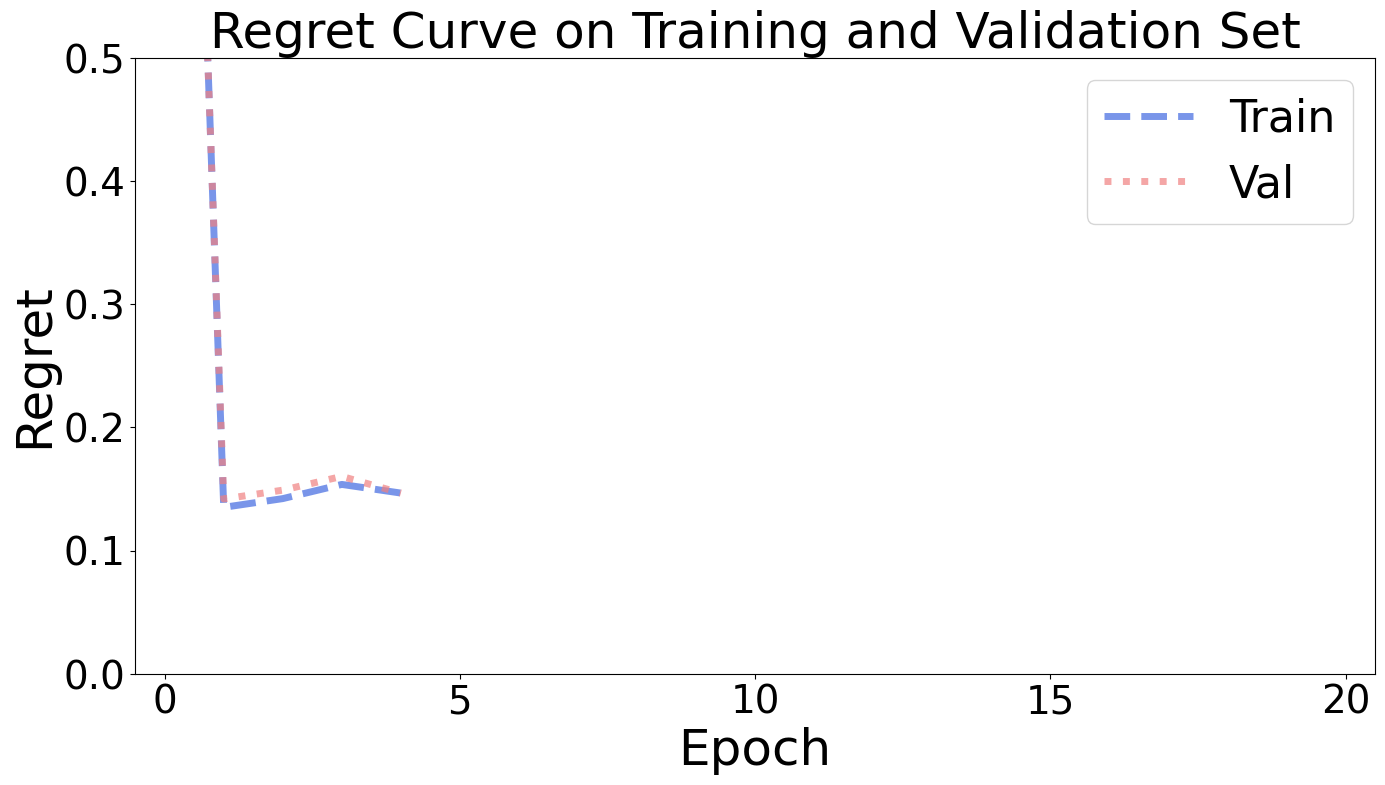

In [31]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Sampling Method with Cone Check

In [32]:
# init model
reg = LinearRegression()

In [33]:
from func import samplingConeAlignedCosine
# init loss
ca_cos = samplingConeAlignedCosine(optmodel, n_samples=100, inner_ratio=0.4, check_cone=True)

Num of cores: 1


In [34]:
lr = 1e-1
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                          | 0/20 [01:58<?, ?it/s]

Epoch   0, Train Regret: 159.7515%, Val Regret: 157.5386%


Epoch    0, Loss:  -0.9994:   5%|██▋                                                  | 1/20 [03:38<39:31, 124.79s/it]

Epoch   1, Train Regret:  13.5975%, Val Regret:  13.9074%


Epoch    1, Loss:  -0.9992:  10%|█████▎                                               | 2/20 [05:11<32:57, 109.84s/it]

Epoch   2, Train Regret:  14.2950%, Val Regret:  14.4267%


Epoch    2, Loss:  -0.9993:  15%|███████▉                                             | 3/20 [06:43<29:00, 102.38s/it]

Epoch   3, Train Regret:  15.3002%, Val Regret:  15.9826%


Epoch    3, Loss:  -0.9978:  20%|██████████▌                                          | 4/20 [08:13<32:53, 123.36s/it]


Epoch   4, Train Regret:  14.8805%, Val Regret:  14.3526%

Early Stop!
Training Elapsed Time: 19.84 Sec

Evaluation:
Test Regret: 14.2107%
Test Elapsed Time: 90.53 Sec


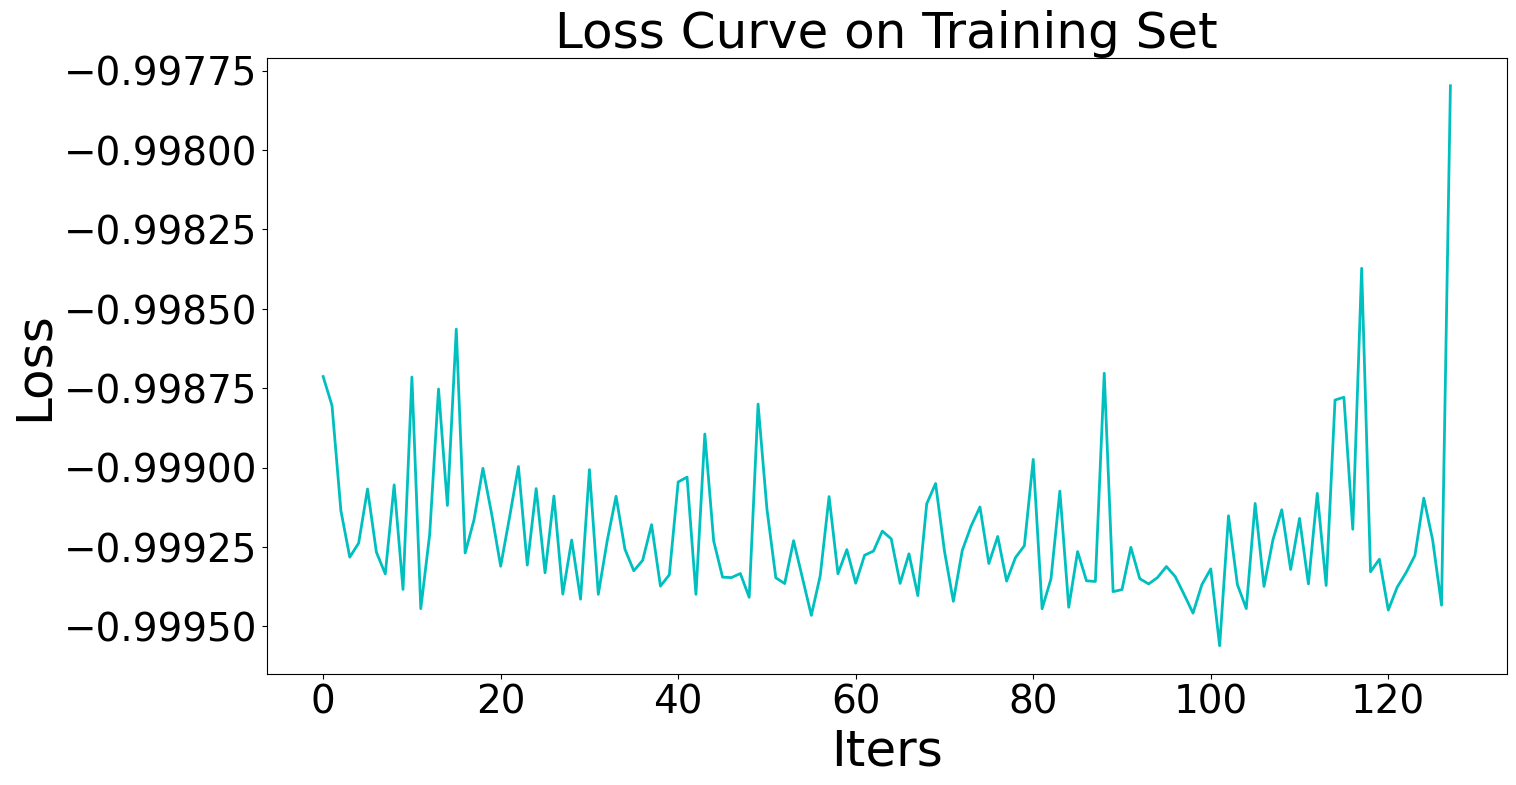

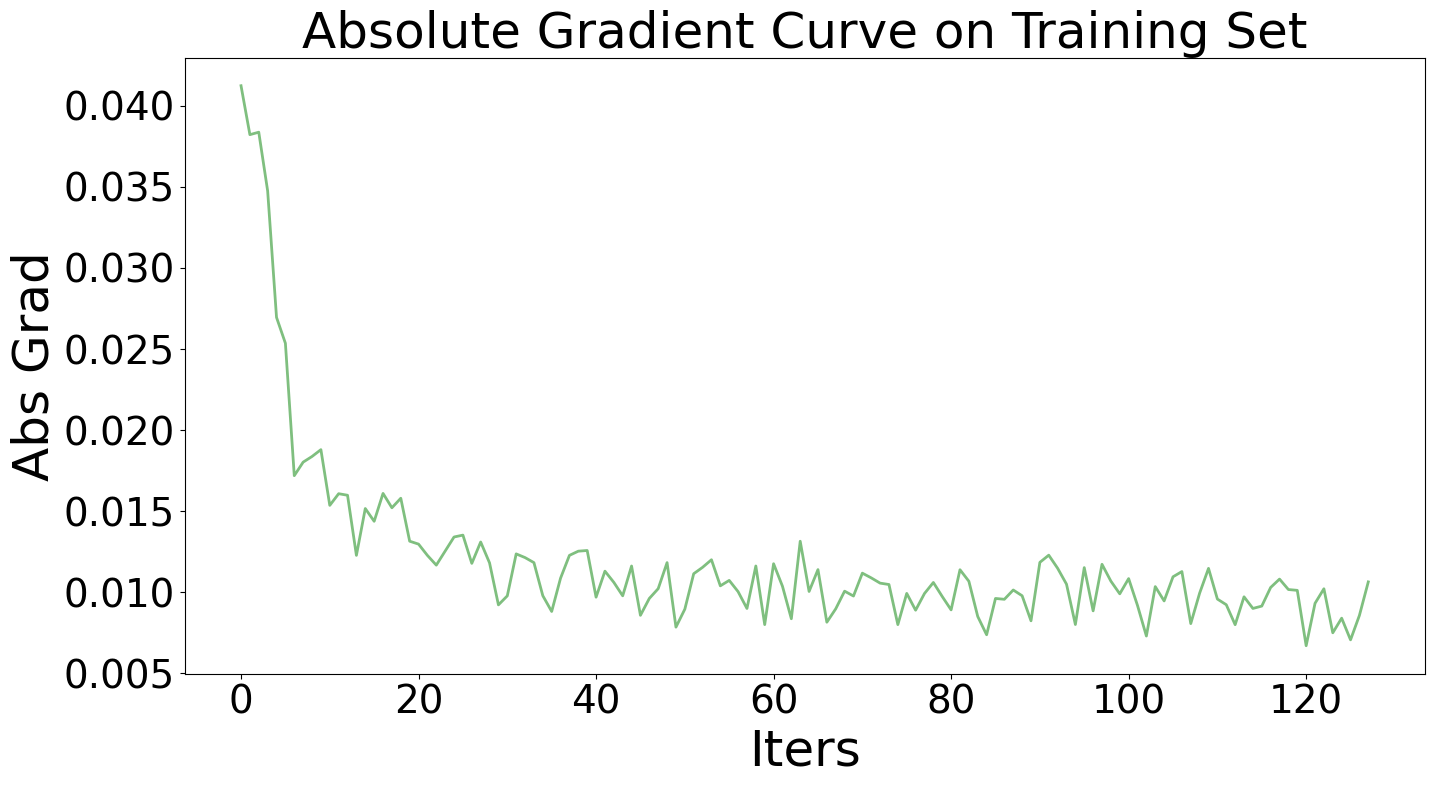

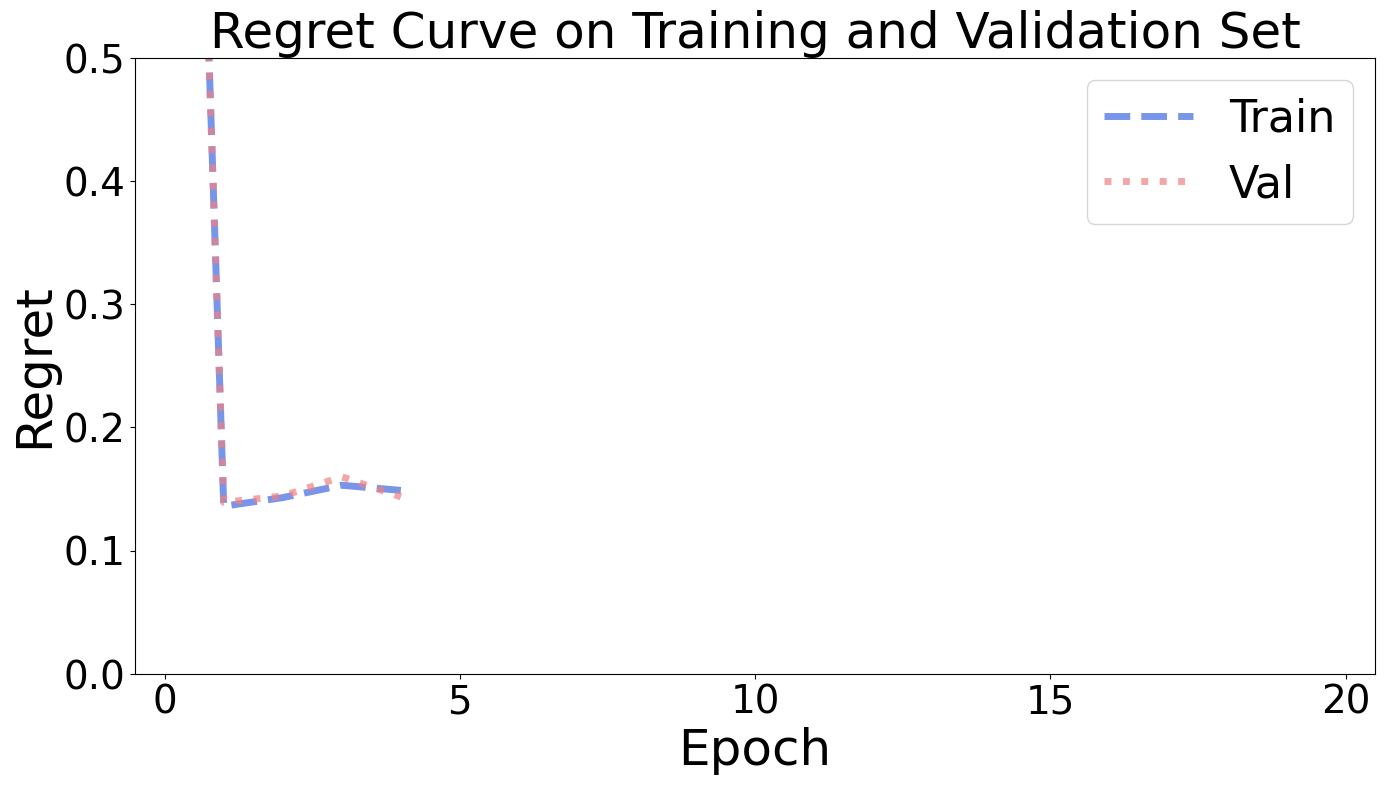

In [35]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Average Method 

In [36]:
# init model
reg = LinearRegression()

In [37]:
from func import avgConeAlignedCosine
# init loss
ca_cos = avgConeAlignedCosine(optmodel, inner_ratio=0.4)

Num of cores: 1


In [38]:
lr = 1e-1
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                          | 0/20 [01:57<?, ?it/s]

Epoch   0, Train Regret: 159.7515%, Val Regret: 157.5386%


Epoch    0, Loss:  -0.9994:   5%|██▋                                                  | 1/20 [03:33<37:29, 118.41s/it]

Epoch   1, Train Regret:  13.8884%, Val Regret:  13.8800%


Epoch    1, Loss:  -0.9993:  10%|█████▎                                               | 2/20 [05:06<31:40, 105.57s/it]

Epoch   2, Train Regret:  14.5762%, Val Regret:  15.1314%


Epoch    2, Loss:  -0.9994:  15%|████████                                              | 3/20 [06:36<28:16, 99.79s/it]

Epoch   3, Train Regret:  15.0859%, Val Regret:  15.6411%


Epoch    3, Loss:  -0.9994:  20%|██████████▌                                          | 4/20 [08:08<32:35, 122.21s/it]


Epoch   4, Train Regret:  14.8842%, Val Regret:  15.7929%

Early Stop!
Training Elapsed Time: 1.65 Sec

Evaluation:
Test Regret: 14.4488%
Test Elapsed Time: 93.77 Sec


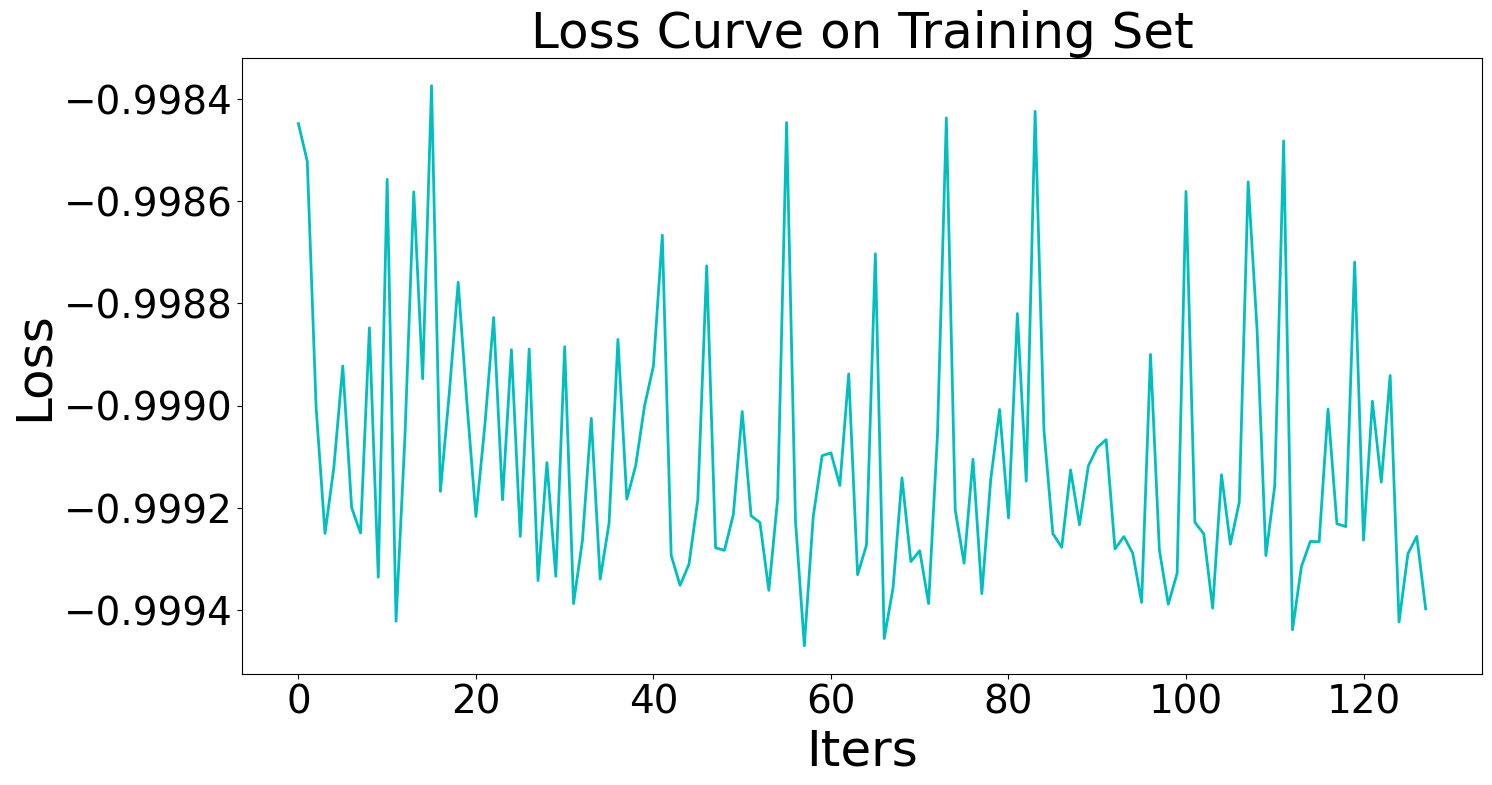

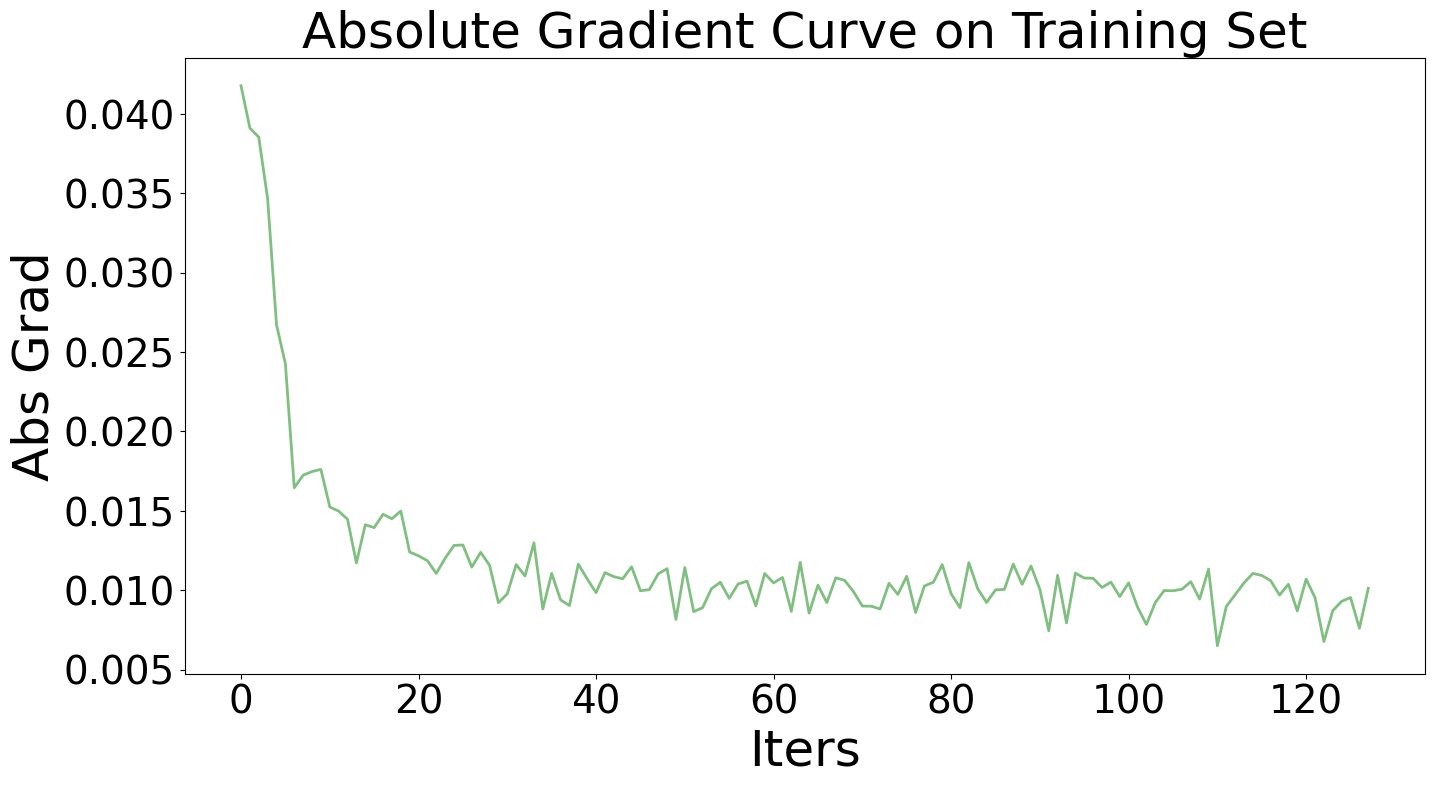

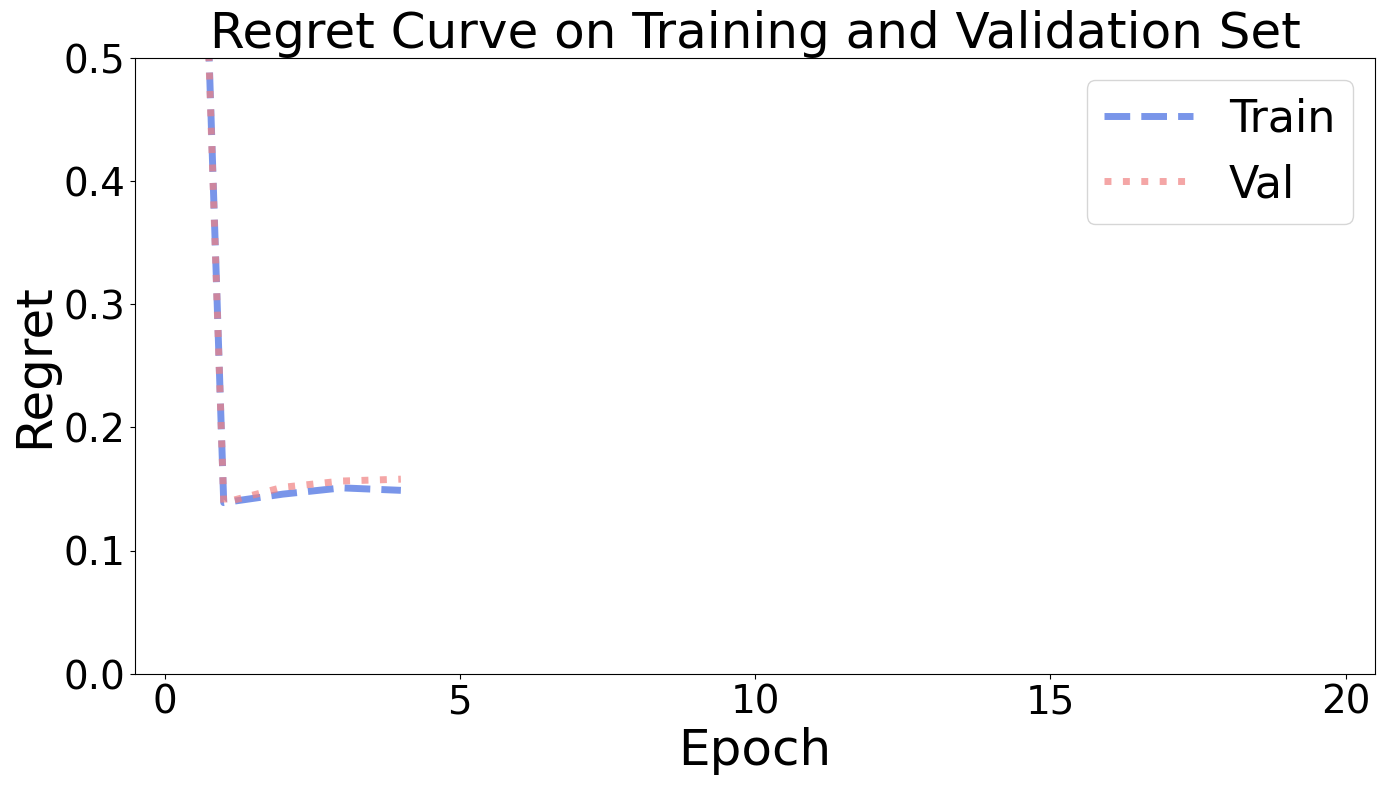

In [39]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

###  Average Method with Cone Check

In [40]:
# init model
reg = LinearRegression()

In [41]:
from func import avgConeAlignedCosine
# init loss
ca_cos = avgConeAlignedCosine(optmodel, inner_ratio=0.4, check_cone=True)

Num of cores: 1


In [42]:
lr = 1e-1
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                          | 0/20 [02:26<?, ?it/s]

Epoch   0, Train Regret: 156.3401%, Val Regret: 161.0864%


Epoch    0, Loss:  -0.9994:   5%|██▋                                                  | 1/20 [04:06<48:02, 151.69s/it]

Epoch   1, Train Regret:  13.8475%, Val Regret:  14.8215%


Epoch    1, Loss:  -0.9993:  10%|█████▎                                               | 2/20 [05:45<36:19, 121.08s/it]

Epoch   2, Train Regret:  14.5970%, Val Regret:  15.5360%


Epoch    2, Loss:  -0.9994:  15%|███████▉                                             | 3/20 [07:18<31:28, 111.10s/it]

Epoch   3, Train Regret:  15.1406%, Val Regret:  15.4460%


Epoch    3, Loss:  -0.9994:  20%|██████████▌                                          | 4/20 [08:54<35:37, 133.61s/it]


Epoch   4, Train Regret:  14.9595%, Val Regret:  15.6844%

Early Stop!
Training Elapsed Time: 16.67 Sec

Evaluation:
Test Regret: 14.7247%
Test Elapsed Time: 94.45 Sec


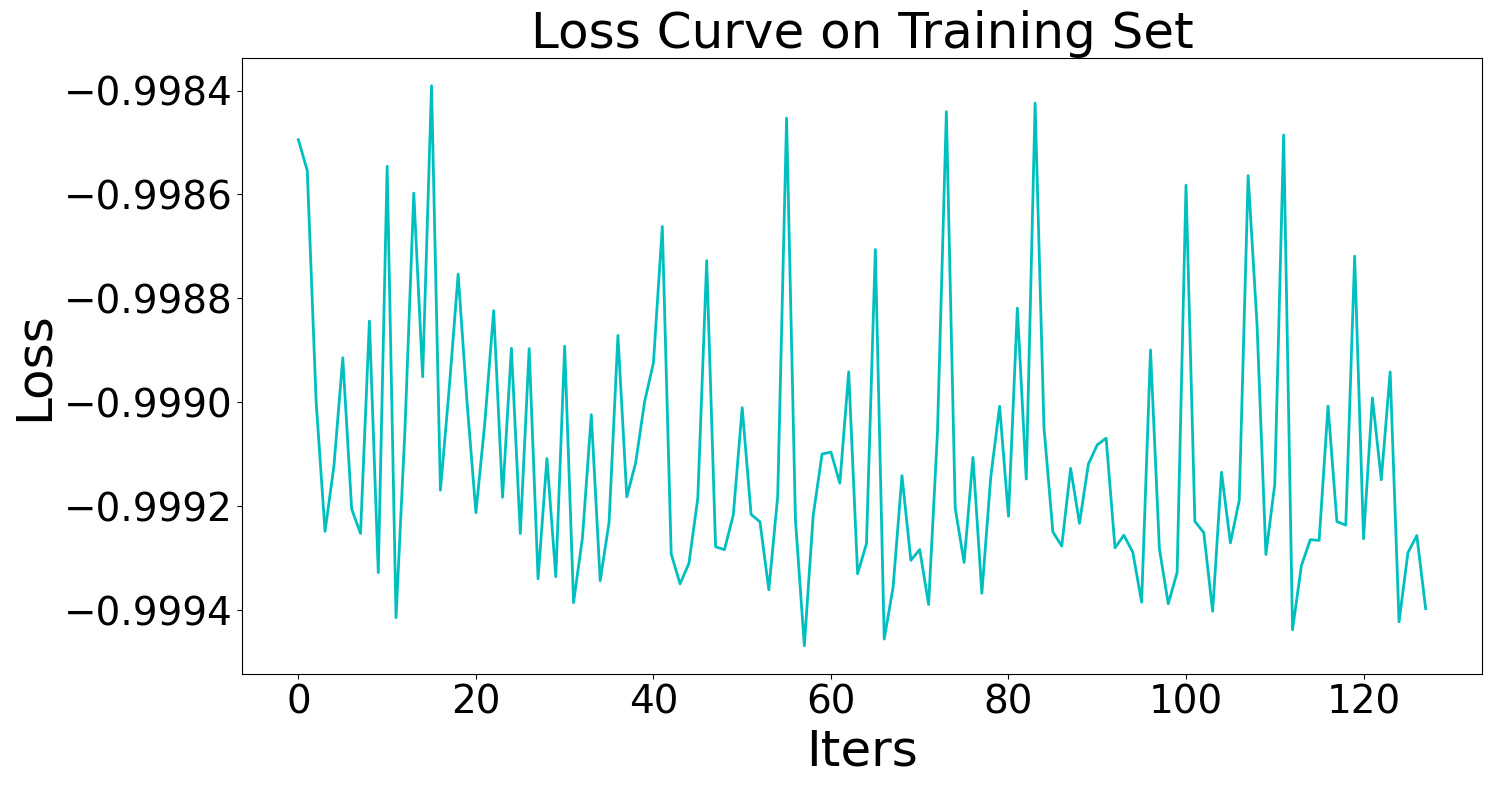

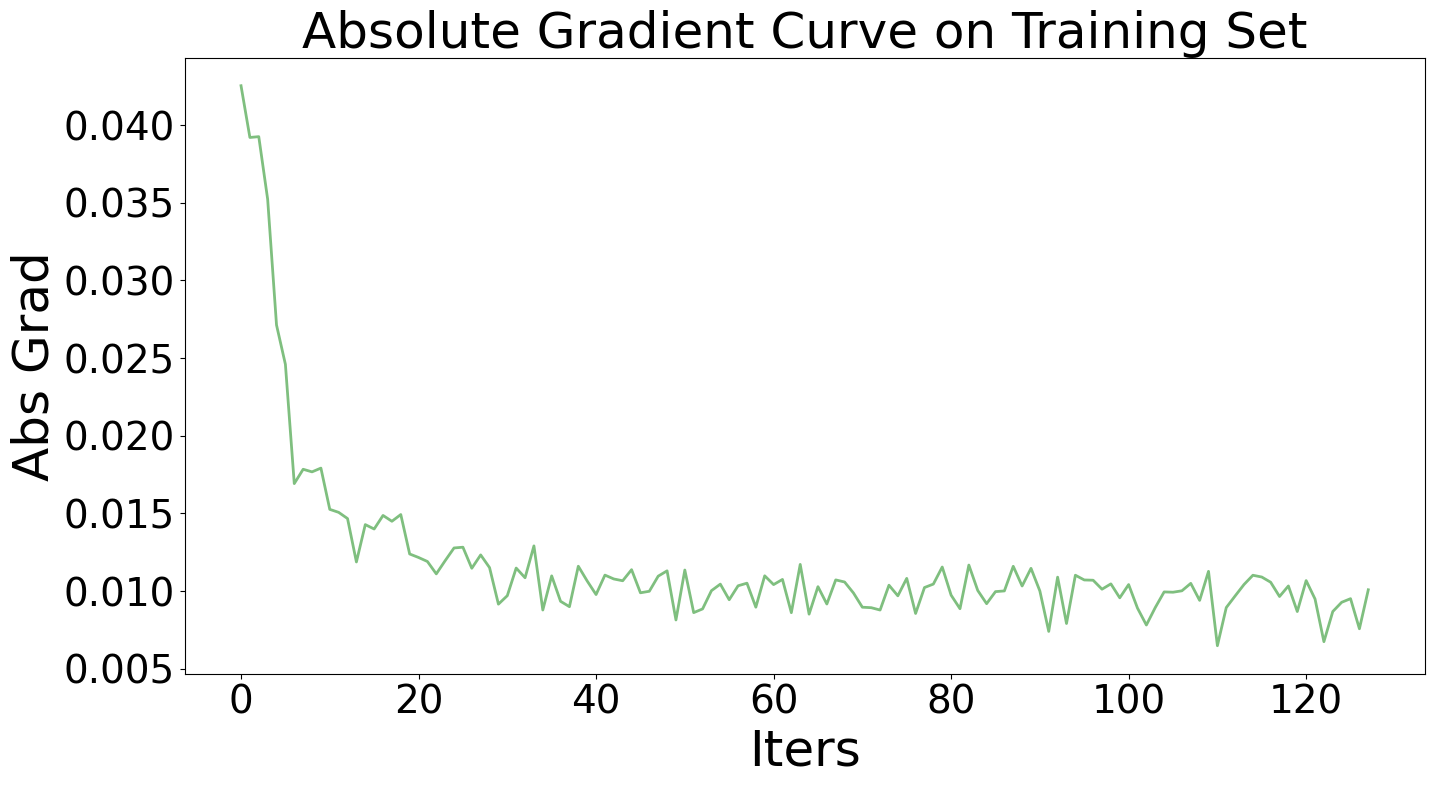

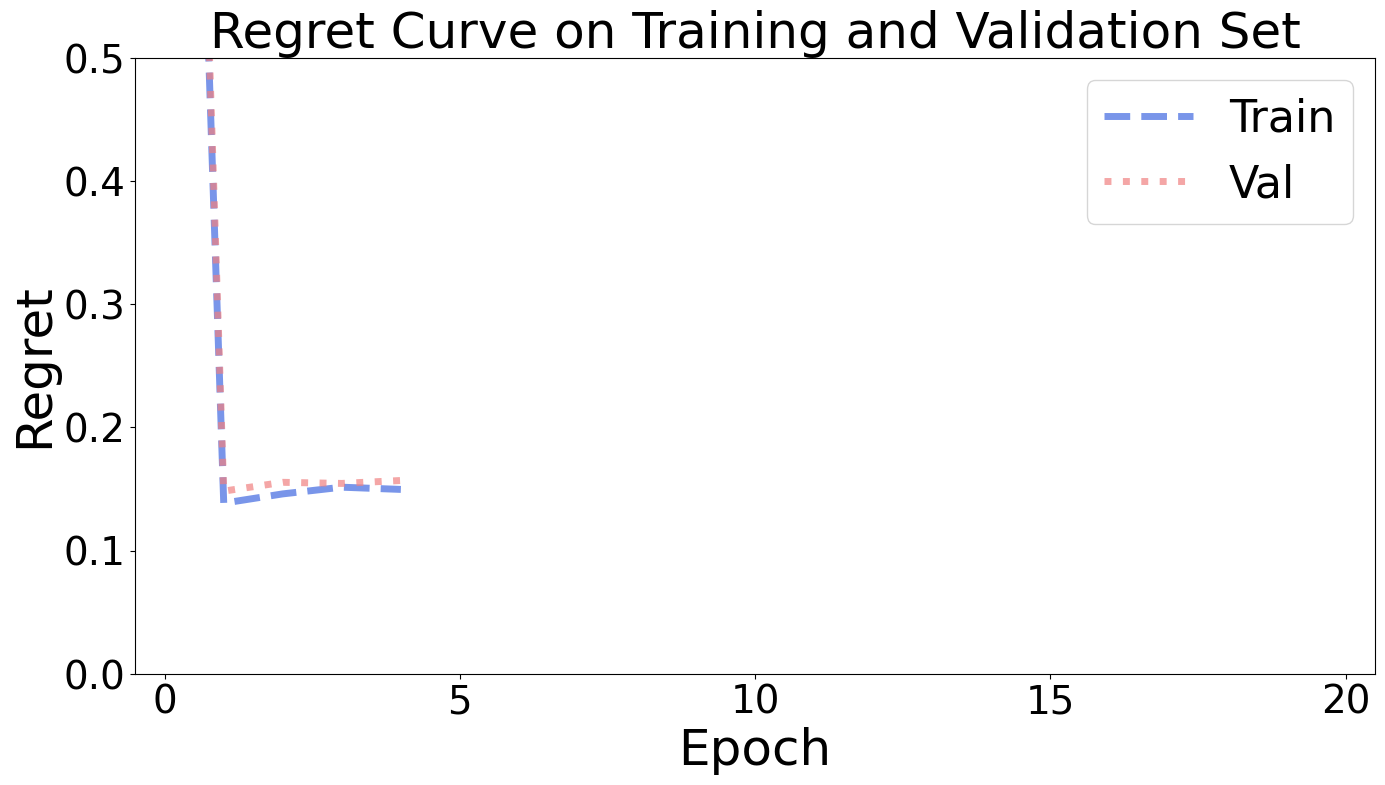

In [43]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### PFYL 

In [44]:
# init model
reg = LinearRegression()

In [45]:
from pyepo.func import perturbedFenchelYoung
# init pfyl loss
pfy = perturbedFenchelYoung(optmodel, n_samples=1, sigma=1.0, processes=8)

def forwardPFY(data, reg, loss_func, grad_log):
    # unzip data
    x, _, w, _ = data
    # predict
    cp = reg(x)
    # get gradient
    cp.register_hook(lambda grad: grad_log.append(abs(grad.cpu().detach().numpy()).sum()))
    # loss
    loss = loss_func(cp, w)
    return loss

Num of cores: 8


In [46]:
lr = 5e-2
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardPFY, pfy, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                          | 0/20 [02:27<?, ?it/s]

Epoch   0, Train Regret: 156.3401%, Val Regret: 161.0864%


Epoch    0, Loss:  21.8750:   5%|██▋                                                  | 1/20 [04:43<57:45, 182.42s/it]

Epoch   1, Train Regret:   9.3347%, Val Regret:  10.0971%


Epoch    1, Loss:  20.7500:  10%|█████▎                                               | 2/20 [07:05<45:38, 152.13s/it]

Epoch   2, Train Regret:   7.2972%, Val Regret:   8.1507%


Epoch    2, Loss:  21.0000:  15%|███████▉                                             | 3/20 [09:44<42:05, 148.56s/it]

Epoch   3, Train Regret:   6.4345%, Val Regret:   7.5728%


Epoch    3, Loss:  18.6250:  20%|██████████▌                                          | 4/20 [12:29<41:16, 154.77s/it]

Epoch   4, Train Regret:   6.1149%, Val Regret:   7.1991%


Epoch    4, Loss:  17.8750:  25%|█████████████▎                                       | 5/20 [15:17<39:31, 158.09s/it]

Epoch   5, Train Regret:   5.9454%, Val Regret:   6.9572%


Epoch    5, Loss:  20.0000:  30%|███████████████▉                                     | 6/20 [18:17<37:56, 162.57s/it]

Epoch   6, Train Regret:   5.9828%, Val Regret:   6.4690%


Epoch    6, Loss:  14.2500:  35%|██████████████████▌                                  | 7/20 [21:39<36:54, 170.34s/it]

Epoch   7, Train Regret:   6.0405%, Val Regret:   7.0334%


Epoch    7, Loss:  14.7500:  40%|█████████████████████▏                               | 8/20 [25:09<36:11, 180.96s/it]

Epoch   8, Train Regret:   5.7029%, Val Regret:   6.6534%


Epoch    8, Loss:  18.6250:  45%|███████████████████████▊                             | 9/20 [28:28<35:04, 191.34s/it]

Epoch   9, Train Regret:   5.7237%, Val Regret:   6.3101%


Epoch    9, Loss:  17.2500:  50%|██████████████████████████                          | 10/20 [31:42<32:02, 192.21s/it]

Epoch  10, Train Regret:   5.5546%, Val Regret:   6.5803%


Epoch   10, Loss:  20.0000:  55%|████████████████████████████▌                       | 11/20 [35:08<29:01, 193.55s/it]

Epoch  11, Train Regret:   5.6166%, Val Regret:   7.6274%


Epoch   11, Loss:  16.7500:  60%|███████████████████████████████▏                    | 12/20 [38:45<25:50, 193.80s/it]


Epoch  12, Train Regret:   5.4653%, Val Regret:   7.0746%

Early Stop!
Training Elapsed Time: 497.47 Sec

Evaluation:
Test Regret: 6.5731%
Test Elapsed Time: 132.47 Sec


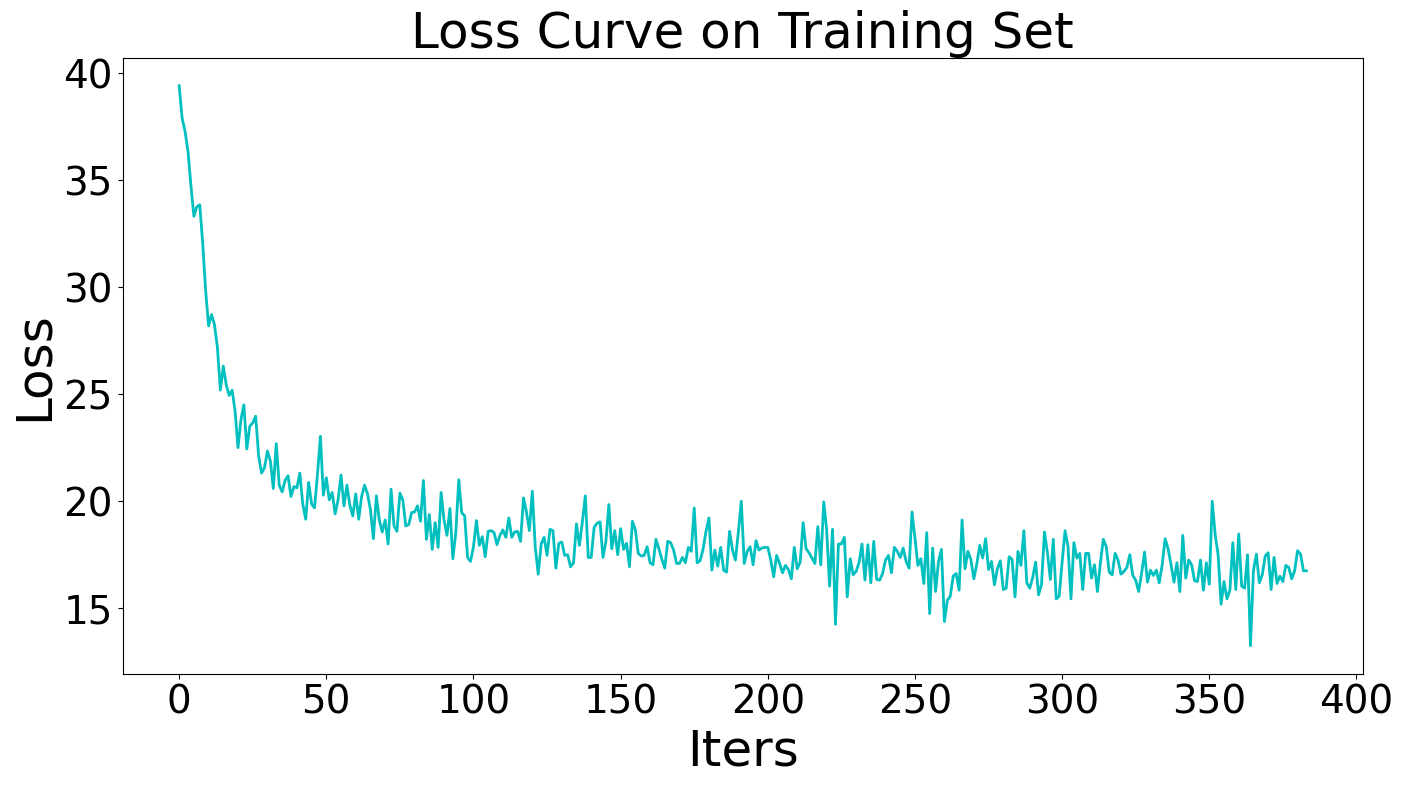

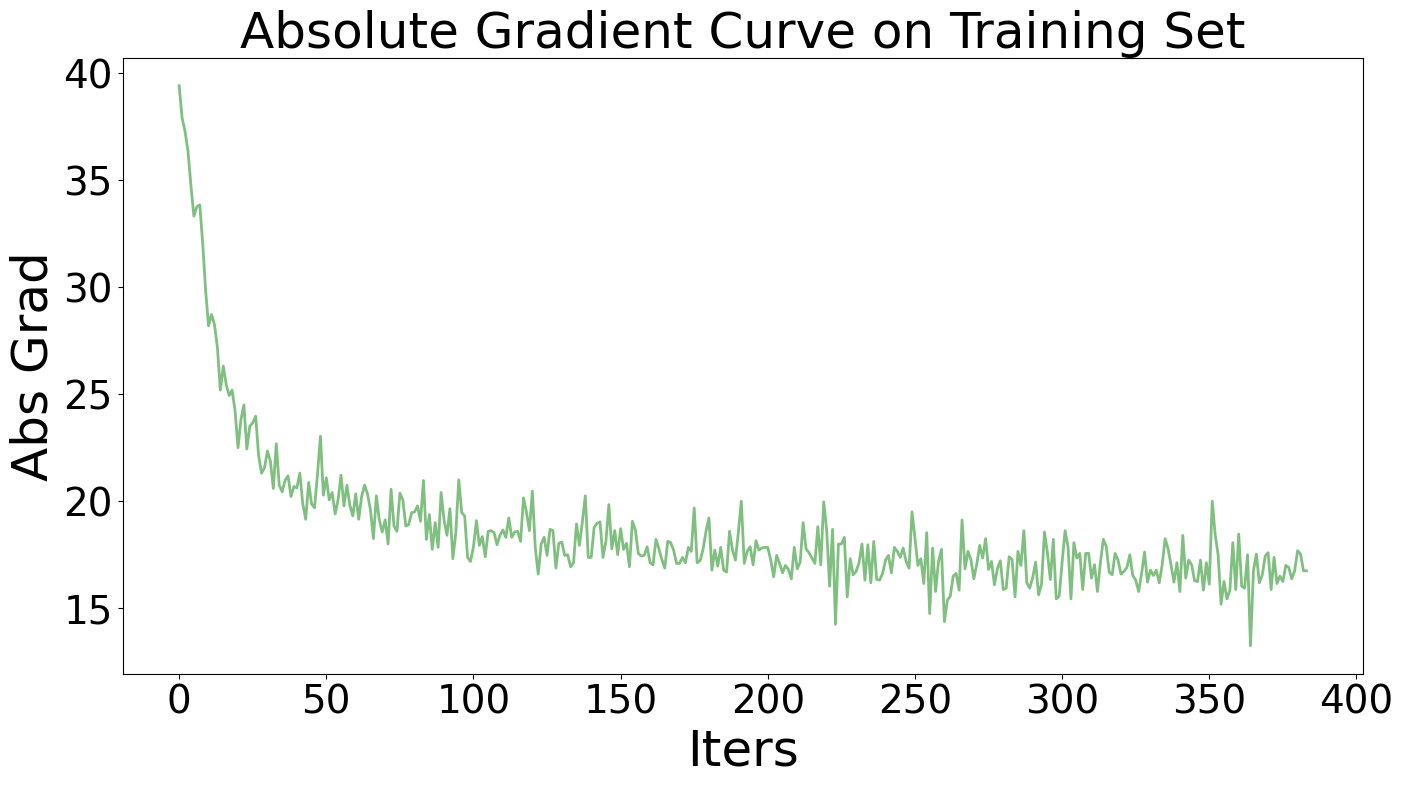

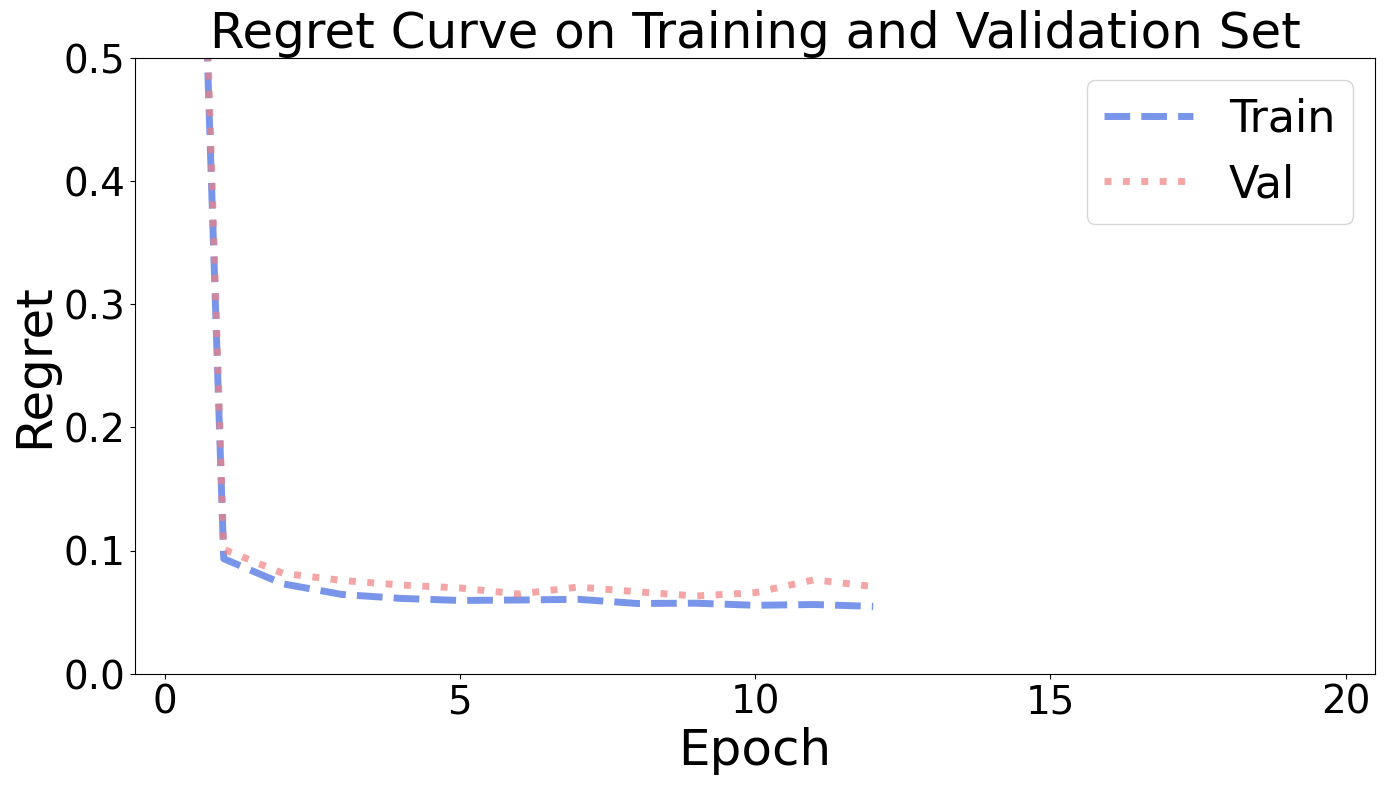

In [47]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### NCE 

In [48]:
# init model
reg = LinearRegression()

In [49]:
from pyepo.func import NCE
# init nce loss
nce = NCE(optmodel, processes=8, solve_ratio=0.05, dataset=dataset_train_cost)

def forwardNCE(data, reg, loss_func, grad_log):
    # unzip data
    x, _, w, _ = data
    # predict
    cp = reg(x)
    # get gradient
    cp.register_hook(lambda grad: grad_log.append(abs(grad.cpu().detach().numpy()).sum()))
    # loss
    loss = loss_func(cp, w)
    return loss

Num of cores: 8


In [50]:
lr = 5e-2
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardNCE, nce, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                          | 0/20 [01:42<?, ?it/s]

Epoch   0, Train Regret: 161.9519%, Val Regret: 162.0717%


Epoch    0, Loss: -62.7231:   5%|██▋                                                  | 1/20 [02:56<33:11, 104.83s/it]

Epoch   1, Train Regret:  18.6901%, Val Regret:  19.2406%


Epoch    1, Loss: -135.3889:  10%|█████▎                                               | 2/20 [04:14<25:55, 86.44s/it]

Epoch   2, Train Regret:  15.8286%, Val Regret:  15.9204%


Epoch    2, Loss: -212.6362:  15%|███████▉                                             | 3/20 [05:34<23:21, 82.45s/it]

Epoch   3, Train Regret:  14.6483%, Val Regret:  15.1988%


Epoch    3, Loss: -301.0388:  20%|██████████▌                                          | 4/20 [06:55<21:47, 81.73s/it]

Epoch   4, Train Regret:  14.0622%, Val Regret:  14.7528%


Epoch    4, Loss: -364.6288:  25%|█████████████▎                                       | 5/20 [08:16<20:23, 81.57s/it]

Epoch   5, Train Regret:  13.4235%, Val Regret:  13.7205%


Epoch    5, Loss: -430.7867:  30%|███████████████▉                                     | 6/20 [09:39<18:59, 81.39s/it]

Epoch   6, Train Regret:  13.1817%, Val Regret:  14.0797%


Epoch    6, Loss: -515.5074:  35%|██████████████████▌                                  | 7/20 [11:01<17:43, 81.78s/it]

Epoch   7, Train Regret:  13.0572%, Val Regret:  13.8650%


Epoch    7, Loss: -659.1287:  40%|█████████████████████▏                               | 8/20 [12:21<16:21, 81.81s/it]

Epoch   8, Train Regret:  12.7324%, Val Regret:  13.6070%


Epoch    8, Loss: -566.0971:  45%|███████████████████████▊                             | 9/20 [13:43<14:54, 81.32s/it]

Epoch   9, Train Regret:  12.5998%, Val Regret:  13.3844%


Epoch    9, Loss: -700.7589:  50%|██████████████████████████                          | 10/20 [15:06<13:36, 81.61s/it]

Epoch  10, Train Regret:  12.4783%, Val Regret:  12.9765%


Epoch   10, Loss: -701.1365:  55%|████████████████████████████▌                       | 11/20 [16:31<12:21, 82.38s/it]

Epoch  11, Train Regret:  12.3110%, Val Regret:  13.3575%


Epoch   11, Loss: -925.3918:  60%|███████████████████████████████▏                    | 12/20 [17:54<11:02, 82.85s/it]

Epoch  12, Train Regret:  12.1799%, Val Regret:  12.9736%


Epoch   12, Loss: -1002.5804:  65%|█████████████████████████████████▏                 | 13/20 [19:16<10:22, 88.96s/it]


Epoch  13, Train Regret:  12.0362%, Val Regret:  13.1075%

Early Stop!
Training Elapsed Time: 18.86 Sec

Evaluation:
Test Regret: 12.9832%
Test Elapsed Time: 72.88 Sec


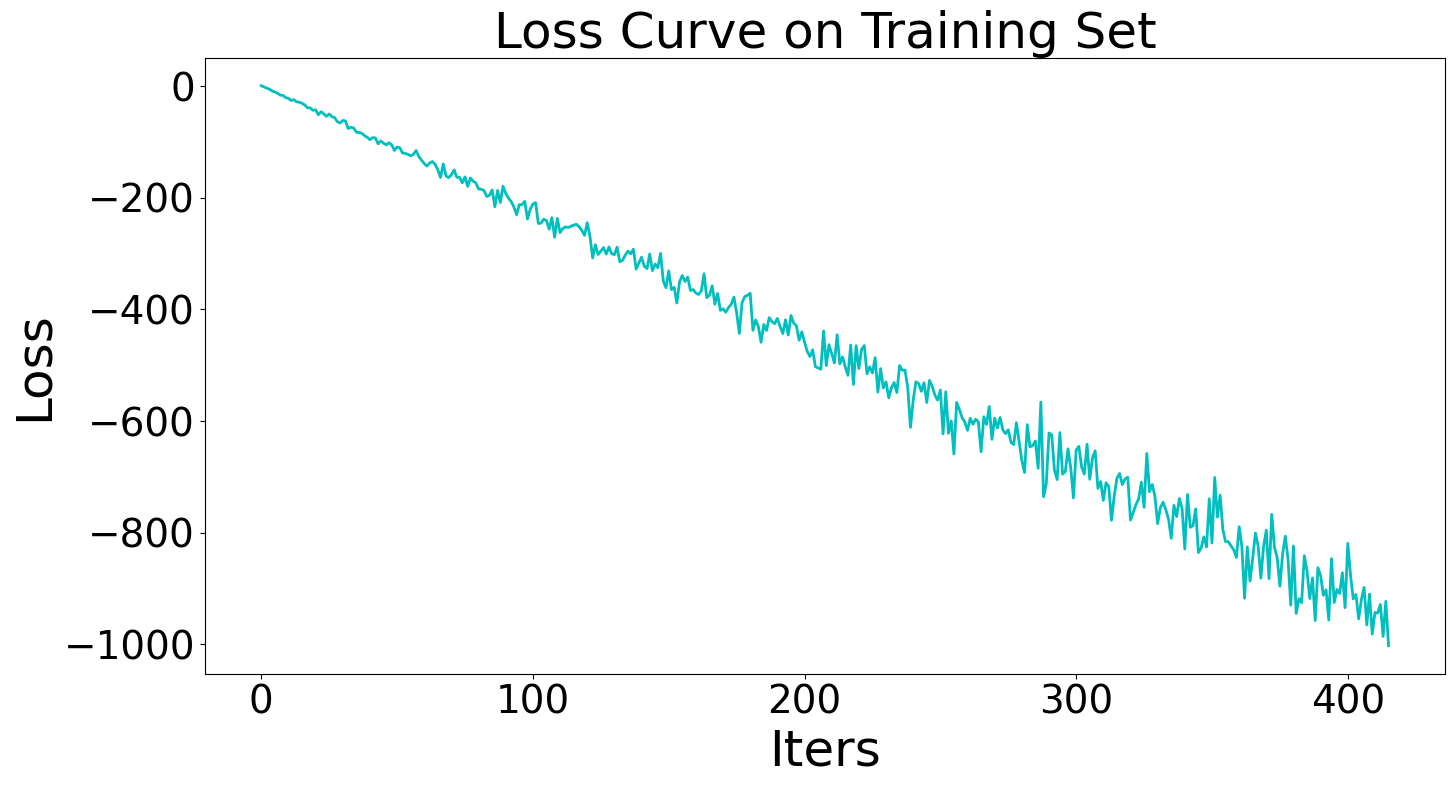

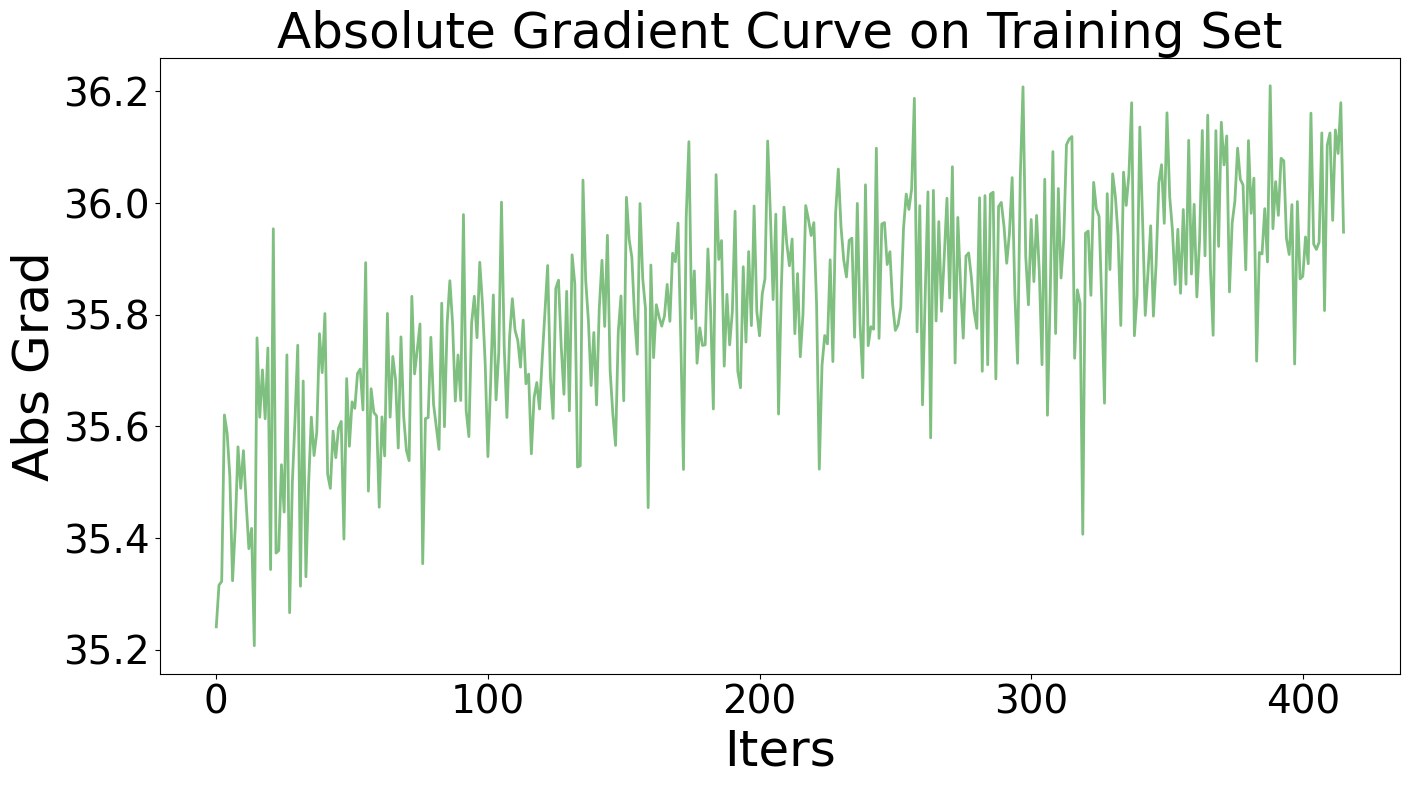

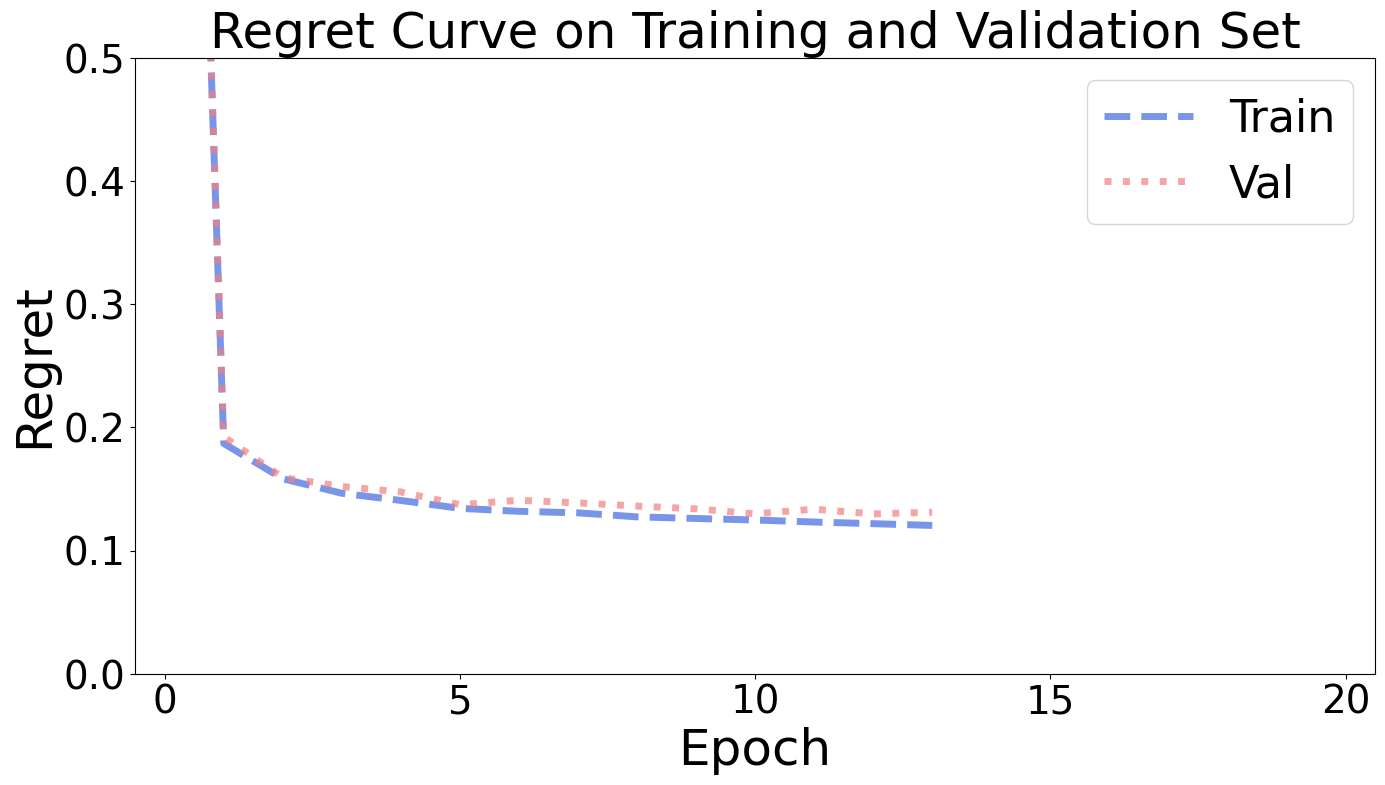

In [51]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)